# **Social Media Electoral Analytics**

- The purpose of this notebook is to generate different metrics (analytics) that can serve as proxys of electoral preference, determinants of participation and identification with political discourses and narratives.

-   The input for this notebook are several thousands of tweets collected longitudinally, from the 18 of april till the 4th of June 1, that contain mentions of the three main political candidates of mexico 2024 presidential election.

- For the classification task, we fined tuned a Robertuito LLM with our own manual classification, to be able to suit and adapt mexican colloquial language and political context to the metrics developed.

# **Index**

- Data Wrangling
- Text Cleaning
- Sentiment Fine-Tuning
- Text Post Cleaning
- Merging new and old dataframes
- Sentiment metrics
- Clustering






## **Data Wrangling**

- We need to clean up the dowloaded tweets so that the have a format available for modelling and text analysis. For that; we have to create a column specific for each candidadate, set up the date and concatenate all the dataframes.

In [ ]:
#Libraries
import re
import pandas as pd
from datetime import datetime
import os
import unicodedata
import pandas as pd
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import AutoTokenizer
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoModelForSequenceClassification
from transformers import AutoModel
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from collections import Counter
from nltk import everygrams
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import string
from collections import Counter
import re
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors
import nltk
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from nltk.stem import SnowballStemmer
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('stopwords')

# Load Spanish stopwords
spanish_stopwords = set(stopwords.words('spanish'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
directory = '/content/drive/My Drive/TWITT'

In [ ]:
save_dir = '/content/plots'
os.makedirs(save_dir, exist_ok=True)

In [ ]:
# Collect all CSV files and sort them based on the presence of specific substrings
file_list = [os.path.join(directory, file) for file in sorted(os.listdir(directory), key=lambda x: ('JAM' in x, 'CS' in x, 'XG' in x)) if file.endswith('.csv')]

dfs = []

# Read each file and append it to the dfs list with the candidate column
for file in file_list:
    df = pd.read_csv(file)
    print("Shape of {}: {}".format(file, df.shape))
    if 'JAM' in file:
        df['Candidato'] = 'JAM'
    elif 'CS' in file:
        df['Candidato'] = 'CS'
    elif 'XG' in file:
        df['Candidato'] = 'XG'
    dfs.append(df)

# Merge all dataframes
df = pd.concat(dfs, ignore_index=True)

# Convert the 'Created At (Mexico City Time)' column to datetime, sort by it, and reset index
df['Created At (Mexico City Time)'] = pd.to_datetime(df['Created At (Mexico City Time)'])
df.sort_values(by='Created At (Mexico City Time)', inplace=True)
df.reset_index(drop=True, inplace=True)

# Get today's date in YYYYMMDD format
today = datetime.now().strftime("%Y%m%d")


Shape of /content/drive/My Drive/TWITT/XG_11_05_24_15:27.csv: (82, 5)
Shape of /content/drive/My Drive/TWITT/XG_12_05_24_21:22.csv: (87, 5)
Shape of /content/drive/My Drive/TWITT/XG_13_05_24_19:19.csv: (88, 5)
Shape of /content/drive/My Drive/TWITT/XG_14_05_24_18:59.csv: (92, 5)
Shape of /content/drive/My Drive/TWITT/XG_15_05_24_20:13.csv: (94, 5)
Shape of /content/drive/My Drive/TWITT/XG_16_05_24_18:42.csv: (95, 5)
Shape of /content/drive/My Drive/TWITT/XG_17_05_24_14:01.csv: (79, 5)
Shape of /content/drive/My Drive/TWITT/XG_18_05_24_14:35.csv: (93, 5)
Shape of /content/drive/My Drive/TWITT/XG_19_05_24_22:00.csv: (97, 5)
Shape of /content/drive/My Drive/TWITT/XG_08_05_24_15:02.csv: (99, 5)
Shape of /content/drive/My Drive/TWITT/XG_01_05_24_19:30.csv: (93, 5)
Shape of /content/drive/My Drive/TWITT/XG_03_05_24_12:48.csv: (93, 5)
Shape of /content/drive/My Drive/TWITT/XG_02_05_24_19:02.csv: (90, 5)
Shape of /content/drive/My Drive/TWITT/XG_06_05_24_15:06.csv: (98, 5)
Shape of /content/dr

In [ ]:
# Drop the 'Author Name' and 'Geolocation' columns
df.drop(['Author Name', 'Geolocation'], axis=1, inplace=True)
# Rename the specified columns
df.rename(columns={'Created At (Mexico City Time)': 'Date', 'Author ID': 'ID'}, inplace=True)

In [ ]:
# Check the number of tweets each candidate has and dataframe general info
print(df['Candidato'].value_counts())
print(df.info())

Candidato
XG     1534
JAM    1519
CS     1498
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4551 entries, 0 to 4550
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       4551 non-null   datetime64[ns]
 1   ID         4551 non-null   int64         
 2   Text       4551 non-null   object        
 3   Candidato  4551 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 142.3+ KB
None




## **Text Cleaning**

- Every tweet needs to be cleaned so that I can have the necessay format to be processed by the LLM

In [ ]:
#Clean the tweet text to remove extra spaces and line breaks
df['Text'] = df['Text'].apply(lambda x: ' '.join(x.split()))

In [ ]:
def clean_text(text):
    # Define the words you want to match in the hashtags
    words_to_match = ['NarcoCandidataClaudia', 'ClaudiaArrasa', 'ClaudiaPresidentaDeMexico2024', 'YoConClaudia', 'EsClaudia',
                      'MiVotoParaXochitl', 'XochitlPresidenta', 'YoConXochitl', 'MiVotoParaXochitl', 'XochitlGalvezPresidenta',
                      'XochitlPresidenta', 'Xochitl2024']

    # Construct a regular expression pattern to match hashtags containing the specified words
    hashtags_pattern = '|'.join(r'\b{}\b'.format(re.escape(word)) for word in words_to_match)

    # Remove HTML tags
    text = re.sub(r'<[^>]*>', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove mentions (assuming mentions start with @)
    text = re.sub(r'@\S+', '', text)

    # Remove hashtags that do not contain the specified words
    text = re.sub(r'#(\S+)', lambda x: x.group(0) if re.search(hashtags_pattern, x.group(1)) else '', text)

    # Remove tildes (accents)
    # This step may not be necessary depending on your analysis requirements
    text = ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')

    # Remove emojis
    text = re.sub(r'[^\w\s,.]', '', text)

    return text

In [ ]:
#Apply the function
df['Cleaned_Text'] = df['Text'].apply(lambda x: clean_text(x))

In [ ]:
#Remove blank cells
df = df[df['Cleaned_Text'].str.strip().astype(bool)]

#Check for duplicated texts
df.duplicated(subset=['Cleaned_Text']).sum()

# Remove rows with duplicated texts in the 'Cleaned_Text' column
df = df.drop_duplicates(subset=['Cleaned_Text'], keep=False)

# Remove spaces between text in the 'Cleaned_Text' column
df['Cleaned_Text'] = df['Cleaned_Text'].str.replace(r'\s+', ' ', regex=True)

# Sort with descending order for date and ascending for 'Candidato'
df.sort_values(by=['Candidato'], ascending=[True], inplace=True)



In [ ]:
#Drop unecessary columns and rename
df.drop(['Text'], axis=1, inplace=True)

# Rename the specified columns
df.rename(columns={'Cleaned_Text': 'Text',}, inplace=True)

In [ ]:
#Save the file to google colab
df.to_csv(f'/content/df_cleaned_{today}.csv', index=False)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3436 entries, 2253 to 4549
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3436 non-null   datetime64[ns]
 1   ID         3436 non-null   int64         
 2   Candidato  3436 non-null   object        
 3   Text       3436 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 134.2+ KB


## **Sentiment Fine-Tuning**

- This is our fine tuned LLM from Robertuito, it needs to be applied to have a sentiment metric.

In [ ]:
# Define the paths to the directory where you saved your model and tokenizer in Google Drive
output_dir_drive = "/content/drive/My Drive/finetuned_model"

In [ ]:
# Load the fine-tuned model
model = AutoModelForSequenceClassification.from_pretrained(output_dir_drive)

In [ ]:
# Load the tokenizer with the same identifier used during training
tokenizer = AutoTokenizer.from_pretrained("pysentimiento/robertuito-sentiment-analysis")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# Load the fine-tuned model and tokenizer
output_dir_drive = "/content/drive/My Drive/finetuned_model"
model = AutoModelForSequenceClassification.from_pretrained(output_dir_drive)
tokenizer = AutoTokenizer.from_pretrained("pysentimiento/robertuito-sentiment-analysis")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# Load your cleaned data set
new_df = df

In [ ]:
# Tokenize the text data in your new dataset
def tokenize_text(text):
    return tokenizer(text, padding=True, truncation=True, return_tensors="pt")

new_encodings = new_df['Text'].apply(tokenize_text)

In [ ]:
# Apply the model for inference
def predict_sentiment_batch(encodings):
    with torch.no_grad():
        outputs = model(**encodings)
    probs = torch.softmax(outputs.logits, dim=1)
    predicted_classes = torch.argmax(probs, dim=1)
    return predicted_classes.tolist(), probs.tolist()

predicted_labels = []
predicted_probs = []
for encodings in new_encodings:
    labels, probs = predict_sentiment_batch(encodings)
    predicted_labels.extend(labels)
    predicted_probs.extend(probs)

In [ ]:
# Add predicted labels and probabilities to the new dataset
new_df['Predicted_Labels'] = predicted_labels
new_df['Predicted_Probabilities'] = predicted_probs

In [ ]:
#Drop unecessary columns and rename
new_df.drop(['Predicted_Probabilities'], axis=1, inplace=True)

# Rename the specified columns
new_df.rename(columns={'Predicted_Labels': 'Sentiment',}, inplace=True)

In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3436 entries, 2253 to 4549
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3436 non-null   datetime64[ns]
 1   ID         3436 non-null   int64         
 2   Candidato  3436 non-null   object        
 3   Text       3436 non-null   object        
 4   Sentiment  3436 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 161.1+ KB


## **Participation Modeling**

- This is our model to predict if a tweet promotes, encourages, mobilizes participation towards a specifc candiate.

- This model was using Roberta based trained with data from National Library of Spain (BNE)

In [ ]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('/content/drive/My Drive/trained_model')

#Ensure the text column is correct
text_column = 'Text'

# Load the model
model = AutoModelForSequenceClassification.from_pretrained('/content/drive/My Drive/trained_model')

# Function to tokenize the dataset
def tokenize_dataset(dataset, tokenizer, text_column, max_length=512):
    encodings = tokenizer(dataset[text_column].tolist(), truncation=True, padding=True, max_length=max_length)
    input_ids = torch.tensor(encodings['input_ids'])
    attention_masks = torch.tensor(encodings['attention_mask'])
    return TensorDataset(input_ids, attention_masks)

# Tokenize the new dataset
tokenized_dataset = tokenize_dataset(new_df, tokenizer, text_column)

# Create a DataLoader for batch processing
batch_size = 32
dataloader = DataLoader(tokenized_dataset, batch_size=batch_size)

In [ ]:
# Load the model
model = AutoModelForSequenceClassification.from_pretrained('/content/drive/My Drive/trained_model')

# Move the model to the appropriate device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Function to classify batches of sentences
def classify_batch(batch):
    inputs = {'input_ids': batch[0].to(device), 'attention_mask': batch[1].to(device)}
    outputs = model(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1).cpu().numpy()
    return predictions

# Apply the classifier to the new DataFrame in batches
all_predictions = []
for batch in dataloader:
    predictions = classify_batch(batch)
    all_predictions.extend(predictions)

In [ ]:
# Add the predictions to the DataFrame
new_df['Particip'] = all_predictions

## **Text Post Cleaning**

- After the LLM model fine tunning, we apply some extra conditions to relate some hashtags and words to positive and negative sentiments towards the candidates.

In [ ]:
# Positive Hashtags for XG
patterns = ['MiVotoParaXochitl', 'XochitlPresidenta', 'YoConXochitl', 'MiVotoParaXochitl', 'XochitlGalvezPresidenta',
            'XochitlPresidenta', 'Xochitl2024']

# Create a function to check if any pattern matches in the text and update 'sentiment' accordingly
def update_sentiment(row):
    if row['Candidato'] == 'XG':
        for pattern in patterns:
            if pattern in row['Text']:
                return 2
    return row['Sentiment']

In [ ]:
# Apply the function to the DataFrame
new_df['Sentiment'] = new_df.apply(update_sentiment, axis=1)

In [ ]:
# Positive Hashtags for CS
patterns_CS = ['ClaudiaArrasa', 'ClaudiaPresidentaDeMexico2024', 'YoConClaudia', 'EsClaudia']

# Create a function to check if any pattern matches in the text and update 'sentiment' accordingly for 'Candidato' == 'CS'
def update_sentiment_CS(row):
    if row['Candidato'] == 'CS':
        for pattern in patterns_CS:
            if pattern in row['Text']:
                return 2
    return row['Sentiment']

In [ ]:
# Apply the function to the DataFrame
new_df['Sentiment'] = new_df.apply(update_sentiment_CS, axis=1)

In [ ]:
# Negative Hashtags and words for CS
patterns_CS = ['NarcoCandidataClaudia', 'NarcoPresidente', 'Calaca', 'calaca', 'Chaira', 'chaira', 'chairo', 'Chairo']

# Create a function to check if any pattern matches in the text and update 'sentiment' accordingly for 'Candidato' == 'CS'
def update_sentiment_CS_NEG(row):
    if row['Candidato'] == 'CS':
        for pattern in patterns_CS:
            if pattern in row['Text']:
                return 1
    return row['Sentiment']

In [ ]:
# Apply the function to the DataFrame
new_df['Sentiment'] = new_df.apply(update_sentiment_CS_NEG, axis=1)

In [ ]:
# Negative Hashtags and words for XG
patterns_CS = ['Botarga', 'botarga', 'panzona', 'Panzona', 'botijona', 'Botijona', 'cebuda', 'Cebuda']

# Create a function to check if any pattern matches in the text and update 'sentiment' accordingly for 'Candidato' == 'CS'
def update_sentiment_XG_NEG(row):
    if row['Candidato'] == 'XG':
        for pattern in patterns_CS:
            if pattern in row['Text']:
                return 1
    return row['Sentiment']

In [ ]:
# Apply the function to the DataFrame
new_df['Sentiment'] = df.apply(update_sentiment_XG_NEG, axis=1)

In [ ]:
# Save the file in case you need to inspect it visually
new_df.to_csv(f'/content/sentiment_df{today}.csv', index=False)

## **Merging new and old dataframes**

- Once we have our new predicted data set with the sentiment metric we need to merge it with the old one, that is the one from previous dates.

- It is important that this data set is contained in the same directory that all the other files in drive.

In [ ]:
# Load the old dataframe with previous tweets
old_df = pd.read_csv('/content/drive/My Drive/Sentiment_ALL.csv')

In [ ]:
#Format date column of he old data frame
old_df['Date'] = pd.to_datetime(old_df['Date'], format='%d/%m/%y', errors='coerce').dt.date

#Format date column of the new data frame
new_df['Date'] = pd.to_datetime(new_df['Date'])
new_df['Date'] = new_df['Date'].dt.date

#Merge both datasets and re-index
df_all = pd.concat([old_df, new_df], ignore_index=True)
df_all = df_all.reset_index()

In [ ]:
#Save file to with the new tweets updated
#df_all.to_csv(f'/content/drive/My Drive/Sentiment_ALL.csv', index=False)

## **Sentiment Metrics**

- In this section we calculate and aggregate the sentiment metrics son that they can be plotted afterwards

In [ ]:
# Due to the fact that we are dealing with a CSV, the dates must be coerced and changed to pd.datetime
df_all['Date'] = pd.to_datetime(df_all['Date'], dayfirst=True, errors='coerce')

In [ ]:
#Split the dataframe into candidates
df_xg = df_all[df_all['Candidato'] == 'XG']
df_cs = df_all[df_all['Candidato'] == 'CS']
df_jam = df_all[df_all['Candidato'] == 'JAM']

In [ ]:
# Crosstab with counts for sentiment metrics
counts_total = pd.crosstab(index= df_all['Date'], columns = df_all['Sentiment'], margins=True,
                           normalize=True)
counts_alltot = counts_total.iloc[-1]
counts_alltot = counts_alltot.multiply(other=100)

counts_xg = pd.crosstab(index=df_xg['Date'], columns=df_xg['Sentiment'], margins=True,
                     normalize= True)
counts_allxg = counts_xg.iloc[-1]
counts_allxg = counts_allxg.multiply(other=100)

counts_cs = pd.crosstab(index=df_cs['Date'], columns=df_cs['Sentiment'], margins=True,
                     normalize= True)
counts_allcs = counts_cs.iloc[-1]
counts_allcs = counts_allcs.multiply(other=100)

counts_jam = pd.crosstab(index=df_jam['Date'], columns=df_jam['Sentiment'], margins=True,
                     normalize= True)
counts_alljam = counts_jam.iloc[-1]
counts_alljam = counts_alljam.multiply(other=100)


In [ ]:
# Crosstab with counts for participation metrics
counts_totalp = pd.crosstab(index= df_all['Date'], columns = df_all['Particip'], margins=True,
                           normalize=True)
counts_alltotp = counts_totalp.iloc[-1]
counts_alltotp = counts_alltotp.multiply(other=100)

counts_xgp = pd.crosstab(index=df_xg['Date'], columns=df_xg['Particip'], margins=True,
                     normalize= True)
counts_allxgp = counts_xgp.iloc[-1]
counts_allxgp = counts_allxgp.multiply(other=100)

counts_csp = pd.crosstab(index=df_cs['Date'], columns=df_cs['Particip'], margins=True,
                     normalize= True)
counts_allcsp = counts_csp.iloc[-1]
counts_allcsp = counts_allcsp.multiply(other=100)

counts_jamp = pd.crosstab(index=df_jam['Date'], columns=df_jam['Particip'], margins=True,
                     normalize= True)
counts_alljamp = counts_jamp.iloc[-1]
counts_alljamp = counts_alljamp.multiply(other=100)


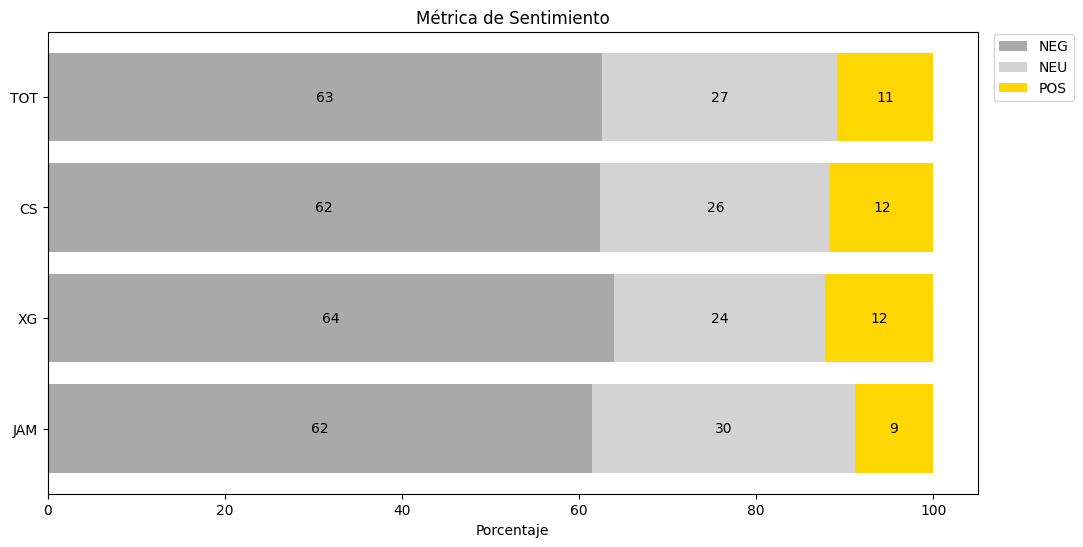

In [ ]:
# Plot the metrics for Sentiment
# Setting up the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Labels and colors for each category
category_labels = ['NEG', 'NEU', 'POS']
colors = ['darkgrey', 'lightgrey', 'gold']  # Dark grey, light grey, dark yellow (gold)

# Adjusting the order of series labels and data
series_labels = ['JAM', 'XG', 'CS', 'TOT']
series_data = [counts_alljam, counts_allxg, counts_allcs, counts_alltot]

# Initially set to handle legend entries
legend_handled = False

# Plotting each category in the stacked bar for each series
for data, series_label in zip(series_data, series_labels):
    cumulative_left = 0  # Start position for each series' segment
    for i, (category_label, color) in enumerate(zip(category_labels, colors)):
        # Plotting each bar segment
        if not legend_handled:
            ax.barh(series_label, data[i], color=color, left=cumulative_left, label=category_label)
        else:
            ax.barh(series_label, data[i], color=color, left=cumulative_left)
        # Center text in the middle of the current segment
        text_position = cumulative_left + data[i] / 2
        ax.text(text_position, series_label, f'{data[i]:.0f}', ha='center', va='center', color='black', fontsize=10)
        # Update the left position for the next bar in this series
        cumulative_left += data[i]
    legend_handled = True  # After the first series, all categories have been added to the legend

ax.set_xlabel('Porcentaje')
ax.set_title('Métrica de Sentimiento')
ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1.01))

save_path = os.path.join(save_dir, 'Métrica de Sentimiento.jpg')
plt.savefig(save_path, format='jpg')

plt.show()


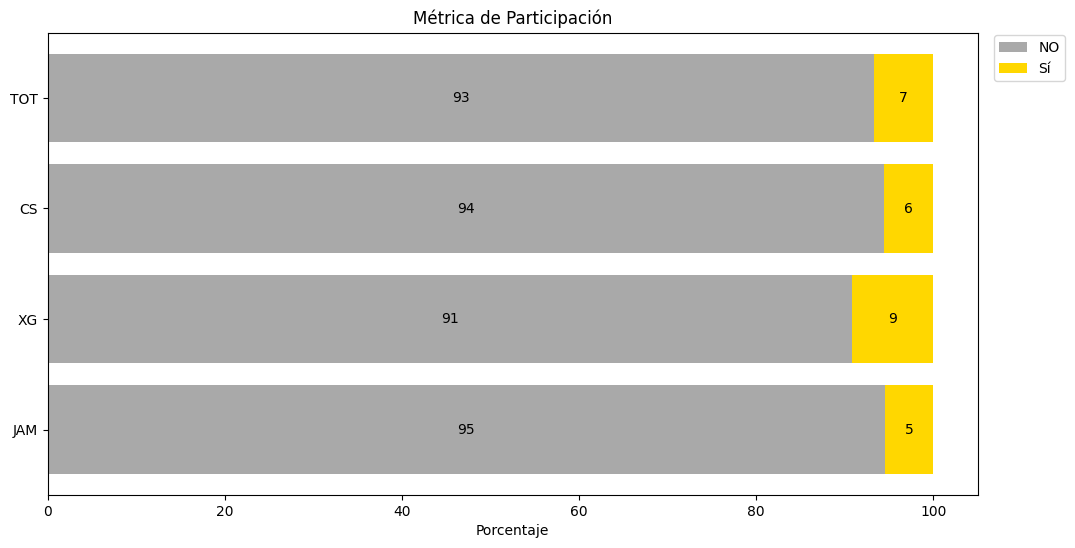

In [ ]:
# Plot the metrics for Participation
# Setting up the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Labels and colors for each category
category_labels = ['NO', 'Sí']
colors = ['darkgrey', 'gold']  # Dark grey, light grey, dark yellow (gold)

# Adjusting the order of series labels and data
series_labels = ['JAM', 'XG', 'CS', 'TOT']
series_data = [counts_alljamp, counts_allxgp, counts_allcsp, counts_alltotp]

# Initially set to handle legend entries
legend_handled = False

# Plotting each category in the stacked bar for each series
for data, series_label in zip(series_data, series_labels):
    cumulative_left = 0  # Start position for each series' segment
    for i, (category_label, color) in enumerate(zip(category_labels, colors)):
        # Plotting each bar segment
        if not legend_handled:
            ax.barh(series_label, data[i], color=color, left=cumulative_left, label=category_label)
        else:
            ax.barh(series_label, data[i], color=color, left=cumulative_left)
        # Center text in the middle of the current segment
        text_position = cumulative_left + data[i] / 2
        ax.text(text_position, series_label, f'{data[i]:.0f}', ha='center', va='center', color='black', fontsize=10)
        # Update the left position for the next bar in this series
        cumulative_left += data[i]
    legend_handled = True  # After the first series, all categories have been added to the legend

ax.set_xlabel('Porcentaje')
ax.set_title('Métrica de Participación')
ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1.01))

save_path = os.path.join(save_dir, 'Métrica de Participación.jpg')
plt.savefig(save_path, format='jpg')

plt.show()

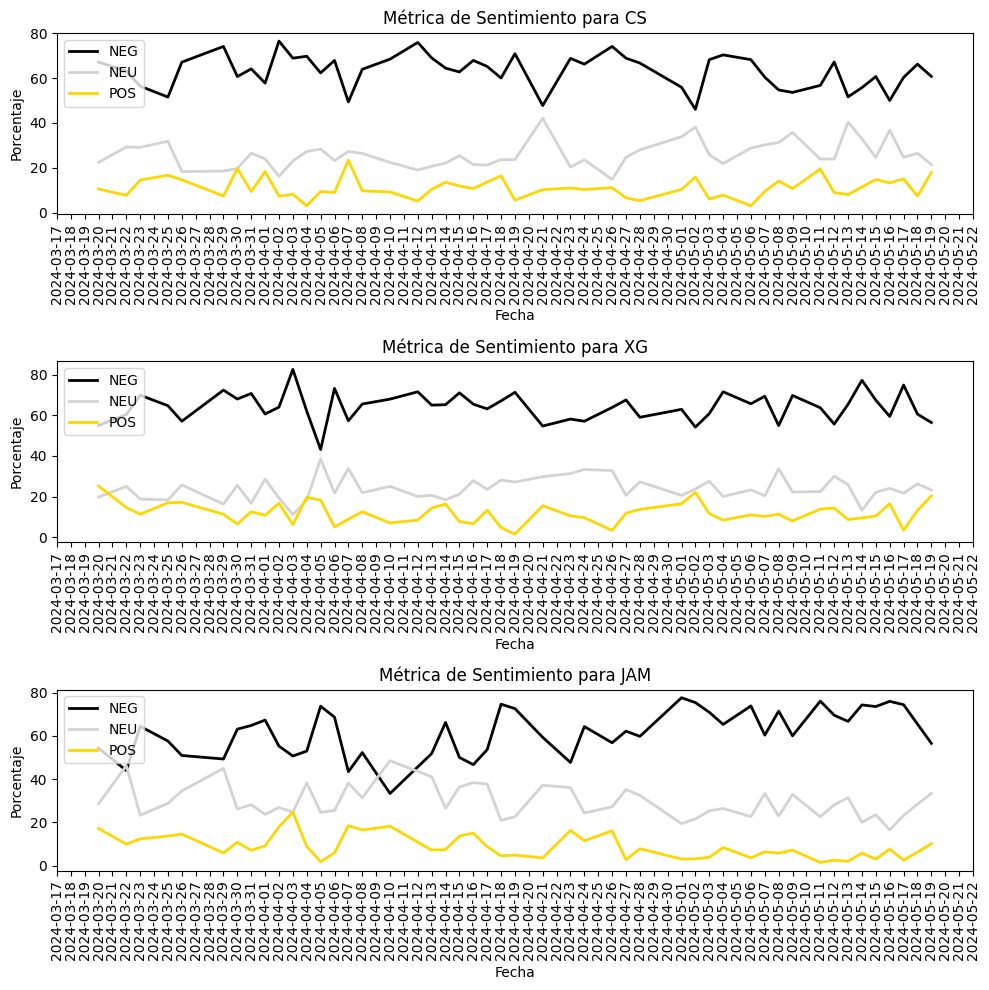

In [ ]:

# Plot the time series for the Sentiment Metric
def plot_separate_sentiment_time_series(dataframes, names):
    plt.figure(figsize=(10, 10))  # Adjusted figure size for better label fit
    start_date = pd.Timestamp('2024-03-20')  # Define the start date for the plots

    # Define new labels and colors
    category_labels = ['NEG', 'NEU', 'POS']
    colors = ['black', 'lightgrey', 'gold']

    # Loop through the list of dataframes and plot each one in a subplot
    for idx, df in enumerate(dataframes):
        ax = plt.subplot(3, 1, idx + 1)  # Creates a subplot in a 3x1 grid

        # Convert 'Date' to datetime type if not already done
        if df['Date'].dtype == 'O' or not np.issubdtype(df['Date'].dtype, np.datetime64):
            df['Date'] = pd.to_datetime(df['Date'])

        # Filter the data to only include dates starting from March 20, 2024
        df = df[df['Date'] >= start_date]

        # Prepare the data: count the occurrences of each sentiment on each date
        sentiment_counts = df.groupby(['Date', 'Sentiment']).size().unstack(fill_value=0)

        # Calculate the percentage of each sentiment for each day
        sentiment_percentages = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100

        # Plotting the time series for each sentiment percentage
        for sentiment in sentiment_percentages.columns:
            ax.plot(sentiment_percentages.index, sentiment_percentages[sentiment],
                     label=f'{category_labels[sentiment]}', color=colors[sentiment], linestyle='-', linewidth=2)

        ax.set_title(f'Métrica de Sentimiento para {names[idx]}')
        ax.set_xlabel('Fecha')
        ax.set_ylabel('Porcentaje')
        ax.legend(loc='upper left')  # Set legend location to upper left

        # Format the date labels on the x-axis
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Set major ticks to daily
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.xticks(rotation=90)  # Rotate date labels to be vertical

        ax.grid(False)  # Disable the grid

    plt.tight_layout()

    save_path = os.path.join(save_dir, 'Serie de tiempo Sentimiento.jpg')
    plt.savefig(save_path, format='jpg')

    plt.show()

# List of dataframes and their names
dataframes = [df_cs, df_xg, df_jam]
names = ['CS', 'XG', 'JAM']

# Generate the separate plots
plot_separate_sentiment_time_series(dataframes, names)


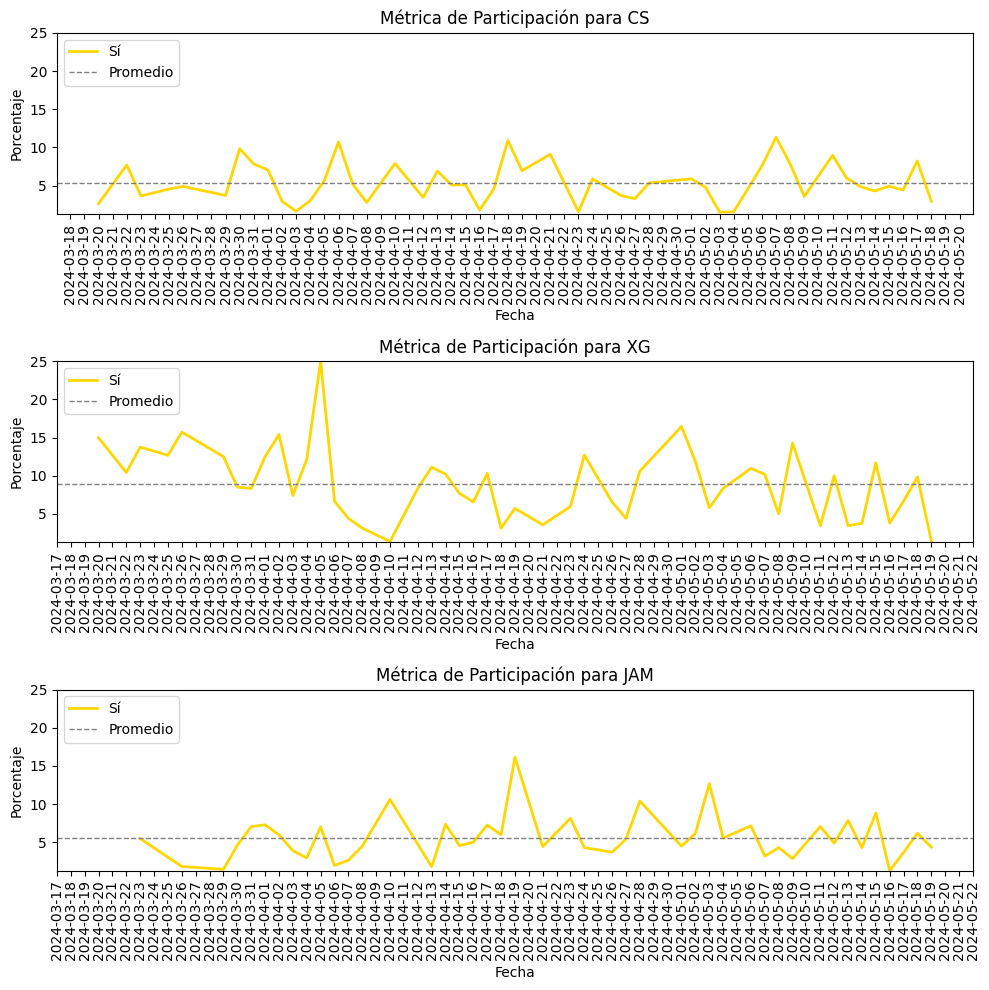

In [ ]:
# Plot the time series for the Participation Metric
def plot_separate_participation_time_series(dataframes, names):
    plt.figure(figsize=(10, 10))  # Adjusted figure size for better label fit
    start_date = pd.Timestamp('2024-03-20')  # Define the start date for the plots

    # Define the color for 'Sí'
    color = 'gold'

    # Calculate the overall min and max percentages
    all_percentages = []
    for df in dataframes:
        df = df[df['Date'] >= start_date]
        participation_counts = df[df['Particip'] == 1].groupby('Date').size()
        total_counts = df.groupby('Date').size()
        participation_percentages = (participation_counts / total_counts) * 100
        all_percentages.extend(participation_percentages.values)

    min_percentage = min(all_percentages)
    max_percentage = max(all_percentages)

    # Loop through the list of dataframes and plot each one in a subplot
    for idx, df in enumerate(dataframes):
        ax = plt.subplot(3, 1, idx + 1)  # Creates a subplot in a 3x1 grid

        # Convert 'Date' to datetime type if not already done
        if df['Date'].dtype == 'O' or not np.issubdtype(df['Date'].dtype, np.datetime64):
            df['Date'] = pd.to_datetime(df['Date'])

        # Filter the data to only include dates starting from March 20, 2024
        df = df[df['Date'] >= start_date]

        # Prepare the data: count the occurrences of participation = 1 ('Sí') on each date
        participation_counts = df[df['Particip'] == 1].groupby('Date').size()

        # Calculate the percentage of 'Sí' participation for each day
        total_counts = df.groupby('Date').size()
        participation_percentages = (participation_counts / total_counts) * 100

        # Plotting the time series for the 'Sí' participation percentage
        if not participation_percentages.empty:
            ax.plot(participation_percentages.index, participation_percentages,
                     label='Sí', color=color, linestyle='-', linewidth=2)

            # Calculate and plot the average line
            average_participation = participation_percentages.mean()
            ax.axhline(y=average_participation, color='grey', linestyle='--', linewidth=1, label='Promedio')

        ax.set_title(f'Métrica de Participación para {names[idx]}')
        ax.set_xlabel('Fecha')
        ax.set_ylabel('Porcentaje')
        ax.legend(loc='upper left')  # Set legend location to upper left

        # Set the y-axis limits to be the same for all subplots
        ax.set_ylim([min_percentage, max_percentage])

        # Format the date labels on the x-axis
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Set major ticks to daily
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.xticks(rotation=90)  # Rotate date labels to be vertical

        ax.grid(False)  # Disable the grid

    plt.tight_layout()

    save_path = os.path.join(save_dir, 'Serie de tiempo Participación.jpg')
    plt.savefig(save_path, format='jpg')

    plt.show()

    plt.show()

# List of dataframes and their names
dataframes = [df_cs, df_xg, df_jam]
names = ['CS', 'XG', 'JAM']

# Generate the separate plots
plot_separate_participation_time_series(dataframes, names)


In [ ]:
#Bi-grams and Tri-grams
# Download and load Spanish stopwords
nltk.download('stopwords')
spanish_stop_words = set(stopwords.words('spanish') + list(string.punctuation))

# Function to clean text and generate n-grams
def clean_and_generate_ngrams(text, n):
    words = word_tokenize(text.lower(), language='spanish')
    words = [word for word in words if word not in spanish_stop_words]
    return [' '.join(grams) for grams in everygrams(words, min_len=n, max_len=n)]

# Filter DataFrames for sentiments 0 and 2 and apply n-grams generation
def filter_and_apply_ngrams(df):
    # Filter for sentiment 0 and 2
    filtered_df = df[df['Sentiment'].isin([0, 2])]
    # Apply bi-grams and tri-grams generation
    filtered_df['Bi-grams'] = filtered_df['Text'].apply(lambda x: clean_and_generate_ngrams(x, 2))
    filtered_df['Tri-grams'] = filtered_df['Text'].apply(lambda x: clean_and_generate_ngrams(x, 3))
    return filtered_df

# Example usage for df_cs, df_xg, df_jam
df_cs_filtered = filter_and_apply_ngrams(df_cs)
df_xg_filtered = filter_and_apply_ngrams(df_xg)
df_jam_filtered = filter_and_apply_ngrams(df_jam)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-48-37256c65869b>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Bi-grams'] = filtered_df['Text'].apply(lambda x: clean_and_generate_ngrams(x, 2))
<ipython-input-48-37256c65869b>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Tri-grams'] = filtered_df['Text'].apply(lambda x: clean_and_generate_ngrams(x, 3))
<ipython-input-48-37256c65869b>:17: Se

Plot saved to /content/plots/Trigramas_CS_NEG.jpg


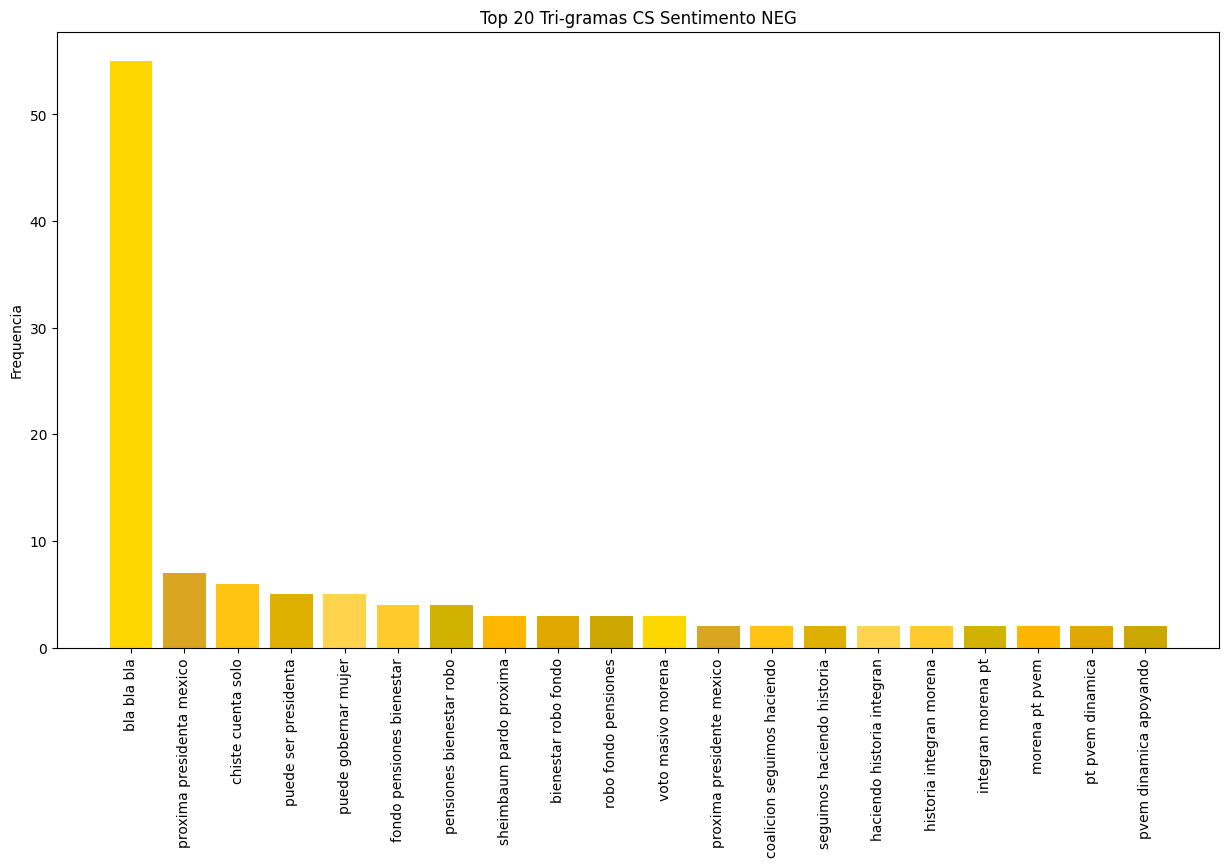

Plot saved to /content/plots/Trigramas_CS_POS.jpg


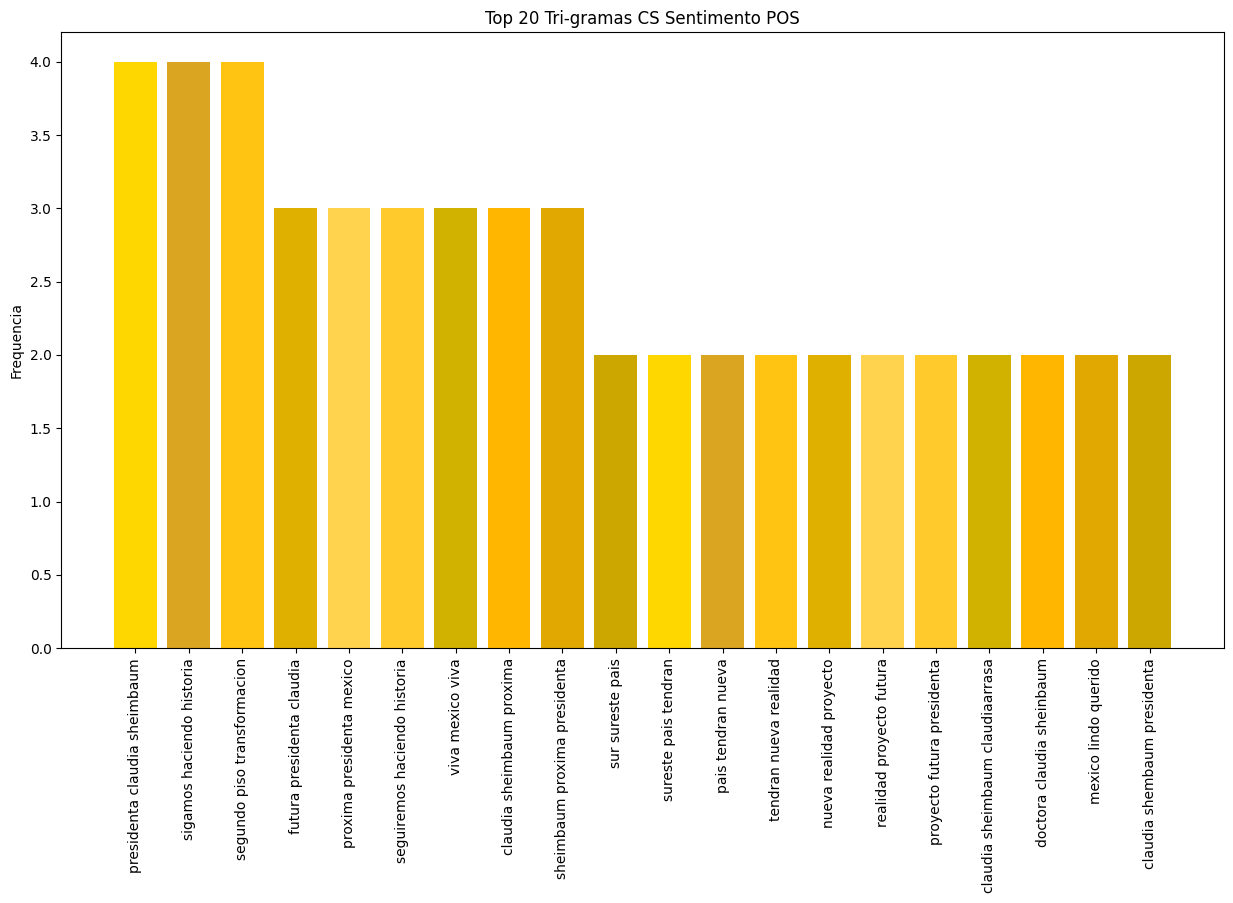

Plot saved to /content/plots/Trigramas_XG_NEG.jpg


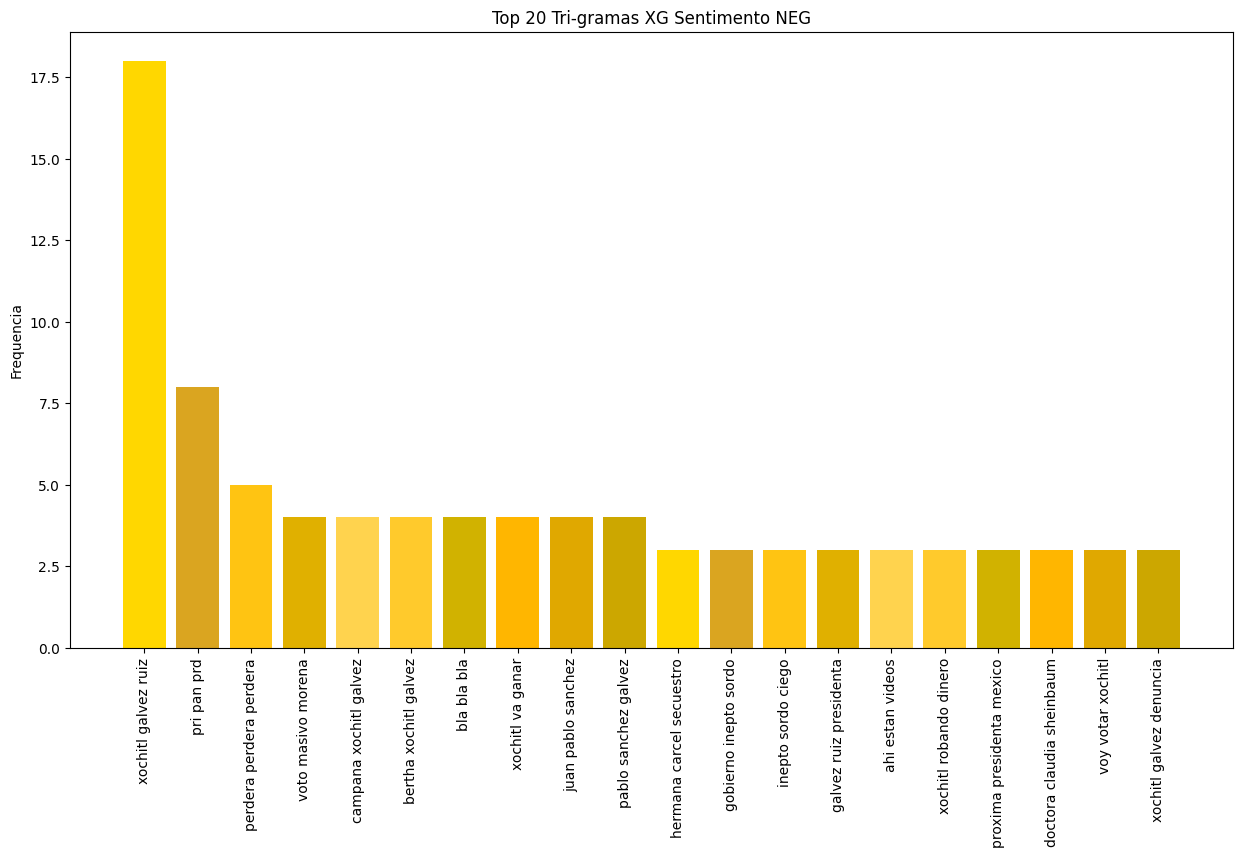

Plot saved to /content/plots/Trigramas_XG_POS.jpg


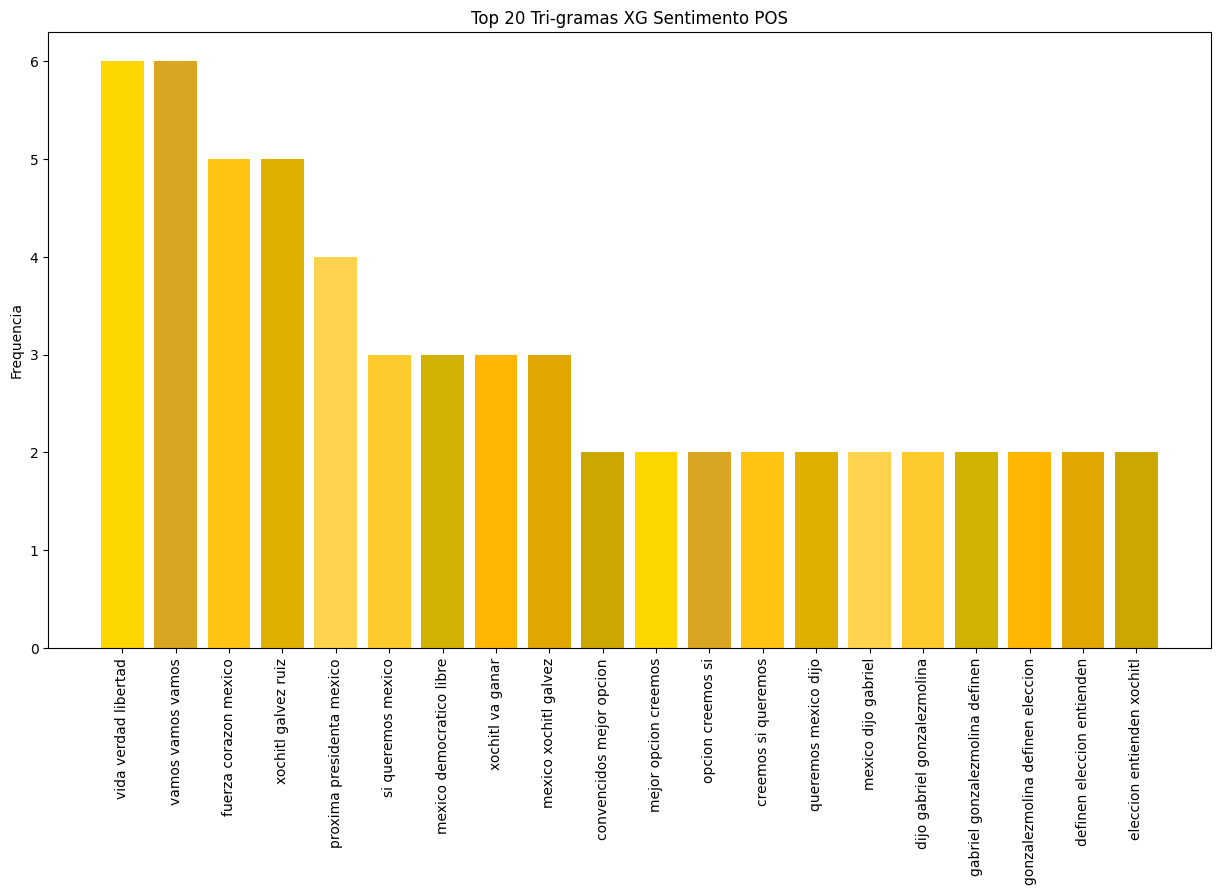

Plot saved to /content/plots/Trigramas_JAM_NEG.jpg


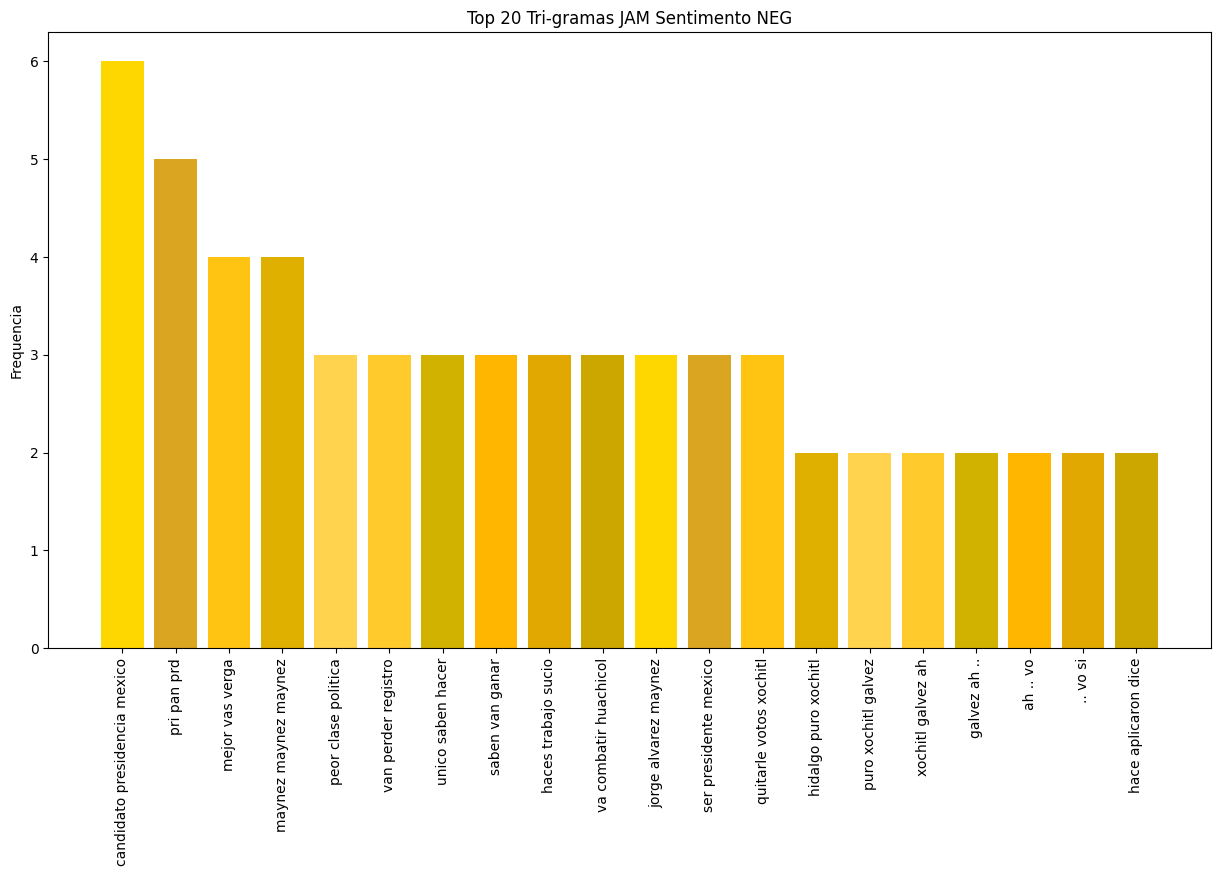

Plot saved to /content/plots/Trigramas_JAM_POS.jpg


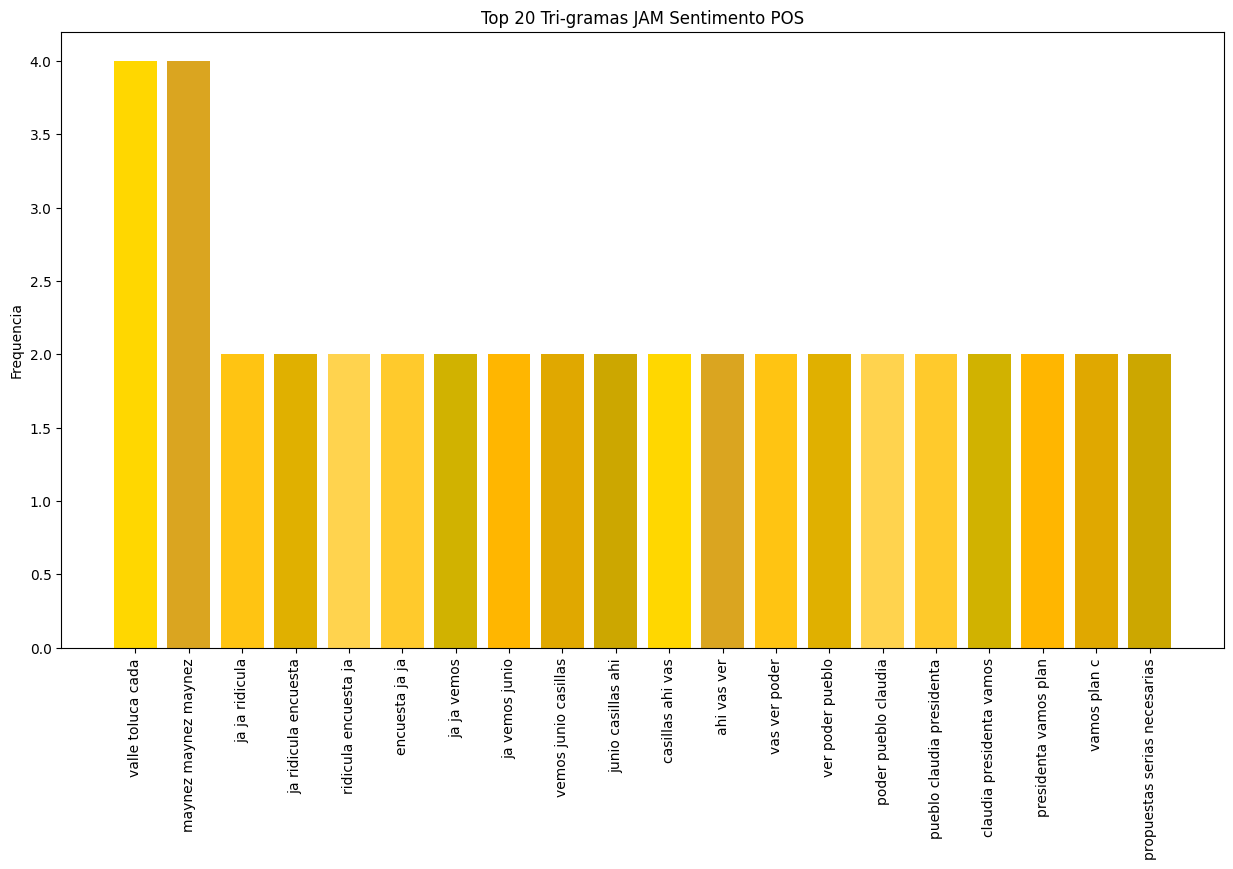

In [ ]:
# Plot the trigrams


# List of tri-grams to omit, normalized to lower case
omit_trigrams = {
    'xohitl galvez ruiz', 'claudia sheimbaum pardo', 'dra claudia sheimbaum',
    'narcocandidataclaudia', 'xochitlpresidenta'
}

# Function to filter out any 'jajaja' variations using regex
def filter_jajaja(trigram):
    # Regular expression to match any repeated 'ja' pattern, regardless of spaces
    pattern = re.compile(r'\b(j\s*a\s*)+\b', re.IGNORECASE | re.VERBOSE)
    # Checking the entire tri-gram against the pattern
    if pattern.search(trigram.replace(' ', '')):
        return False
    return True

# Function to normalize and check if a trigram should be omitted
def should_omit_trigram(trigram):
    normalized_trigram = ' '.join(trigram.lower().split())  # Normalize spaces and case
    return any(omit_trigram in normalized_trigram for omit_trigram in omit_trigrams)

# Define sentiment labels here
sentiment_labels = {
    0: 'NEG',
    2: 'POS'
}

# Function to plot top 20 tri-grams for specific sentiment
def plot_top_trigrams(df, title, sentiment, save_dir):
    # Filter DataFrame for the specified sentiment
    sentiment_df = df[df['Sentiment'] == sentiment]

    # Flatten list of tri-grams into a single list
    all_trigrams = [
        trigram for sublist in sentiment_df['Tri-grams']
        for trigram in sublist
        if not should_omit_trigram(trigram) and filter_jajaja(trigram)
    ]

    # Count the tri-grams and get the top 20
    trigram_counts = Counter(all_trigrams)
    top_trigrams = trigram_counts.most_common(20)

    # Separate the tri-grams and their counts
    trigrams, counts = zip(*top_trigrams)

    # Create color scale in shades of dark yellow
    colors = ['#FFD700', '#DAA520', '#FFC412', '#E0B000', '#FFD34E', '#FFCA2C', '#D1B200', '#FFB600', '#E0A800', '#CCA700'] * 2  # Repeat the color pattern

    # Plotting
    plt.figure(figsize=(15, 8))  # Adjusted figure size for better visibility
    plt.bar(trigrams, counts, color=colors)
    plt.ylabel('Frequencia')
    plt.title(f'Top 20 Tri-gramas {title} Sentimento {sentiment_labels[sentiment]}')
    plt.xticks(rotation=90)  # Making x-axis labels vertical

    # Save the plot with a unique filename
    save_path = os.path.join(save_dir, f'Trigramas_{title}_{sentiment_labels[sentiment]}.jpg')
    plt.savefig(save_path, format='jpg', bbox_inches='tight', pad_inches=0.2)
    print(f"Plot saved to {save_path}")


    plt.show()

# Assuming df_cs_filtered, df_xg_filtered, df_jam_filtered are already loaded and contain a 'Tri-grams' column
save_dir = '/content/plots'  # Directory should already be created

for df, name in zip([df_cs_filtered, df_xg_filtered, df_jam_filtered], ["CS", "XG", "JAM"]):
    if 0 in df['Sentiment'].unique():  # Check if the sentiment '0' exists before plotting
        plot_top_trigrams(df, name, 0, save_dir)  # For sentiment = 0
    if 2 in df['Sentiment'].unique():  # Check if the sentiment '2' exists before plotting
        plot_top_trigrams(df, name, 2, save_dir)  # For sentiment = 2




## **Clustering**

- In this section we will create a series of cluster that can relate different words with each of the candidates.

In [ ]:
# We first need to Tokenize, Vectorize and create a model of word vectors.

# Load Spanish stopwords
spanish_stopwords = set(stopwords.words('spanish'))

def preprocess_text(text):
    """Tokenize text and remove stopwords."""
    tokens = word_tokenize(text, language='spanish')
    return [token.lower() for token in tokens if token.lower() not in spanish_stopwords and token.isalpha()]

# Gather all texts from the datasets into a single list for model training
def prepare_texts(datasets):
    all_texts = []
    for df in datasets.values():
        processed_texts = df['Text'].apply(preprocess_text)
        all_texts.extend(processed_texts)
    return all_texts

# Assuming df_cs, df_xg, df_jam are already loaded and contain a 'Text' column
datasets = {
    'CS Dataset': df_cs,
    'XG Dataset': df_xg,
    'JAM Dataset': df_jam
}

# Prepare data for training
all_texts = prepare_texts(datasets)

# Train a Word2Vec model
model = Word2Vec(sentences=all_texts, vector_size=100, window=5, min_count=2, workers=4)

# The we need to vectorize the texts prior to clustering
def vectorize_texts(texts, model):
    """Generate vectors for list of preprocessed texts using a Word Embedding model."""
    features = []
    for tokens in texts:
        zero_vector = np.zeros(model.vector_size)
        vectors = [model.wv[token] for token in tokens if token in model.wv]

        if vectors:
            vectors = np.array(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

def get_vectorized_data(df, model):
    """Applies preprocessing and vectorization to the text data in a DataFrame."""
    df['processed_text'] = df['Text'].apply(preprocess_text)
    df['vectors'] = vectorize_texts(df['processed_text'].tolist(), model)
    return df

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Processing CS...
Plot saved to /content/plots/Importancia_de_Palabras_CS.jpg


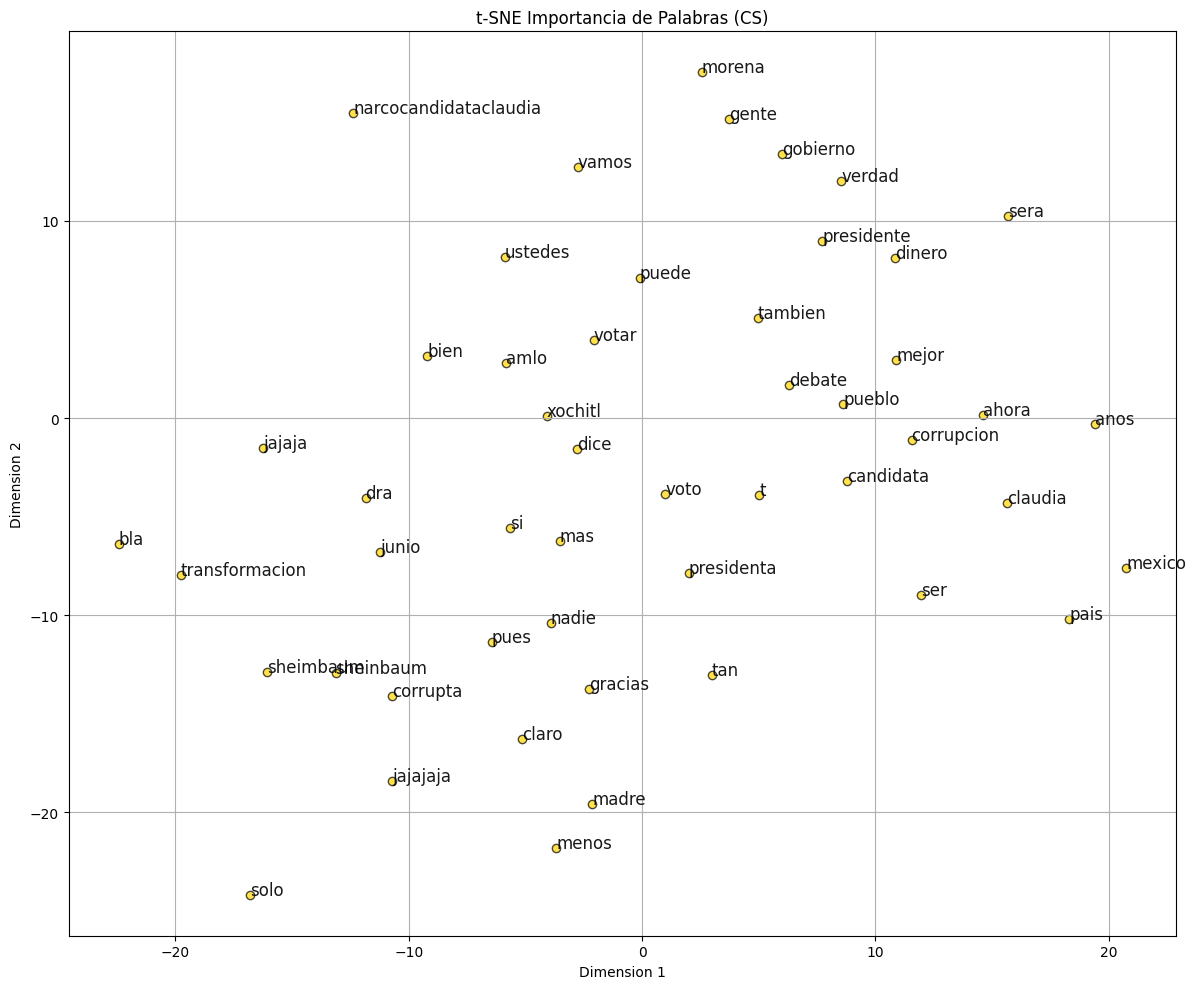

Processing XG...
Plot saved to /content/plots/Importancia_de_Palabras_XG.jpg


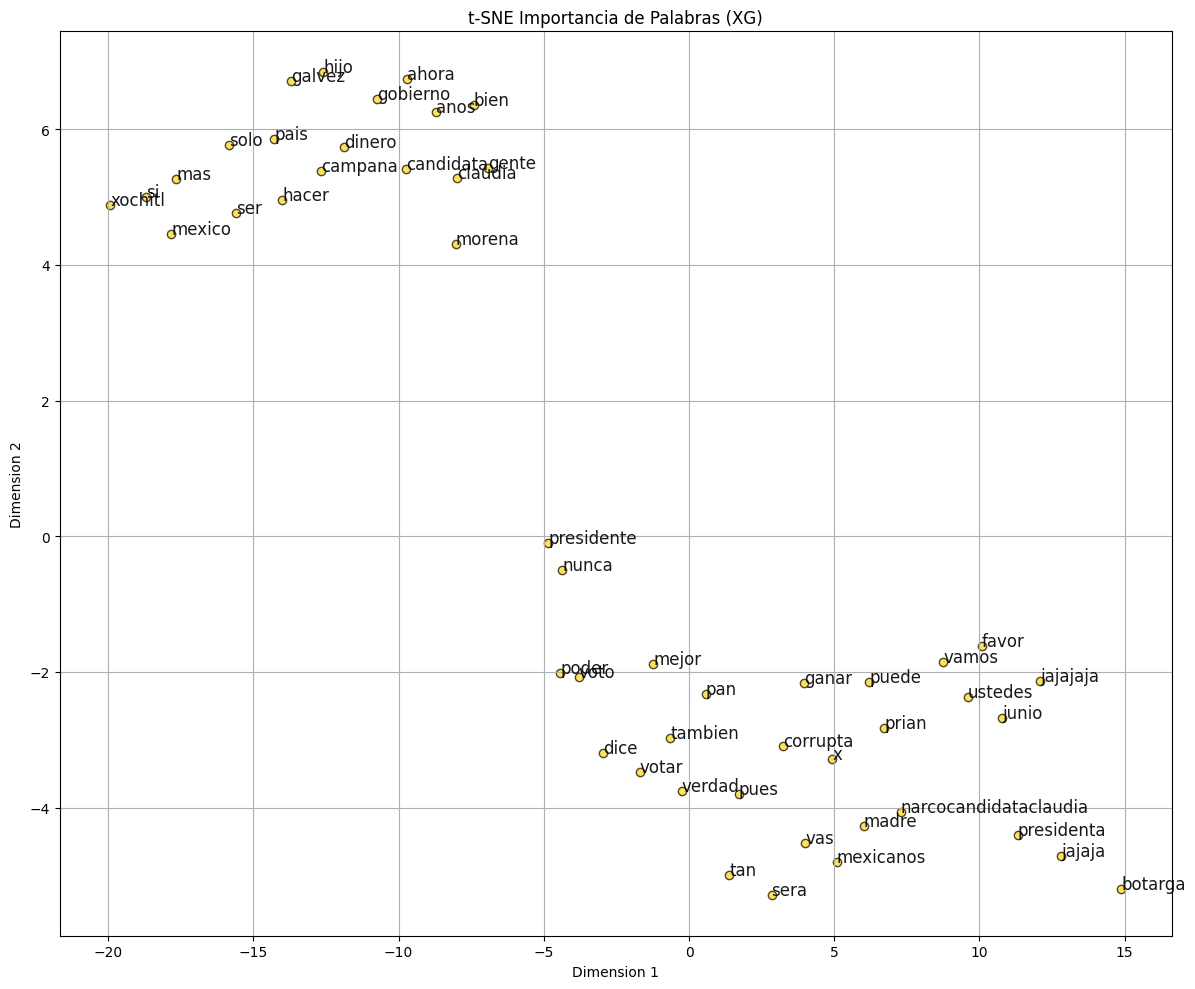

Processing JAM...
Plot saved to /content/plots/Importancia_de_Palabras_JAM.jpg


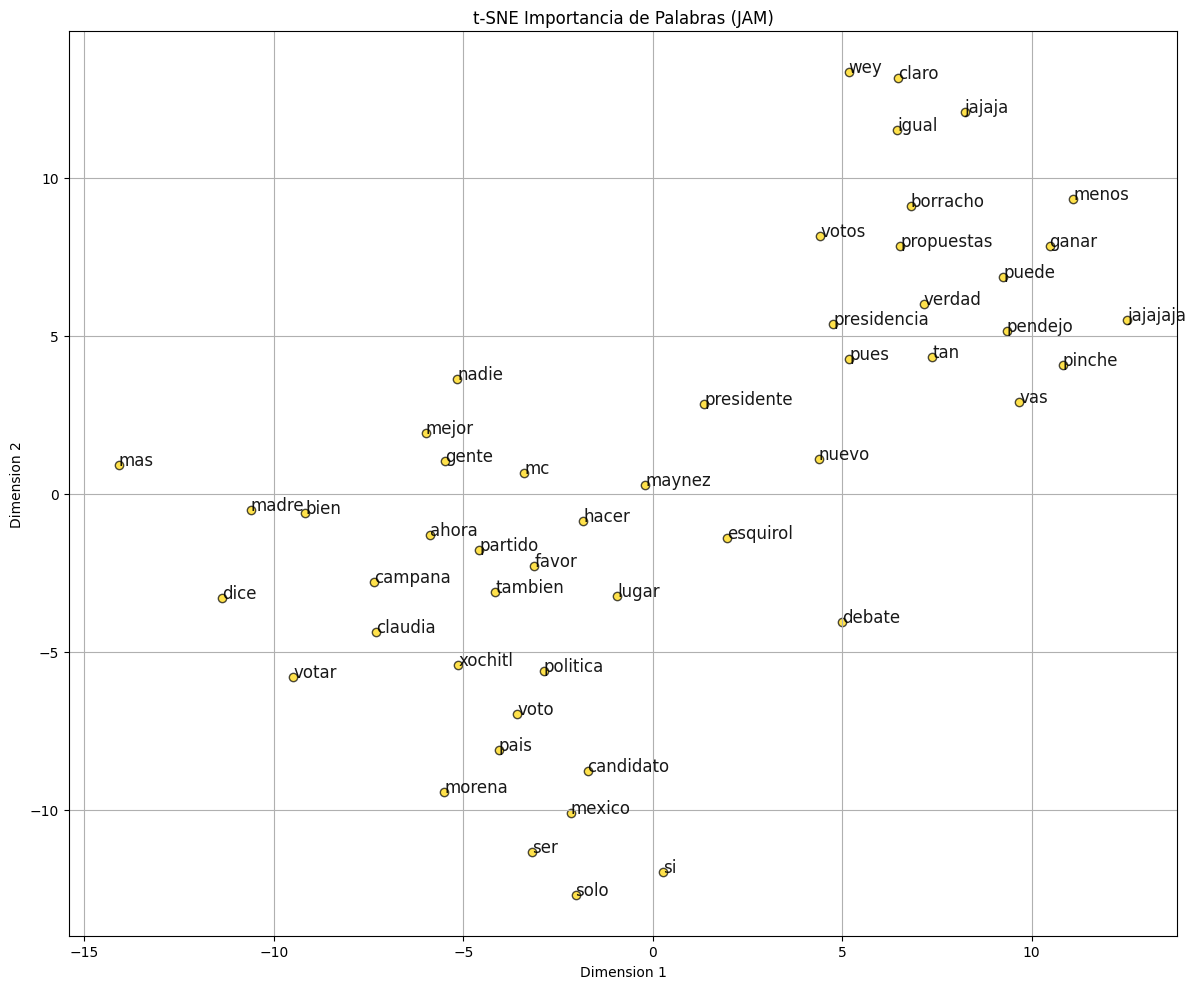

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Load Spanish stopwords
spanish_stopwords = set(stopwords.words('spanish'))

words_to_omit = {'hace', 'van', 'q', 'ver', 'ahi', 'asi', 'estan', 'va'}

def preprocess_text(text):
    """Tokenize text and remove stopwords."""
    tokens = word_tokenize(text, language='spanish')
    return [token.lower() for token in tokens if token.lower() not in spanish_stopwords and token.isalpha()]

def prepare_texts(df):
    processed_texts = df['Text'].apply(preprocess_text)
    return processed_texts.tolist()

def train_word2vec_model(texts):
    model = Word2Vec(vector_size=100, window=5, min_count=2, workers=4, seed=42)
    model.build_vocab(texts)  # Explicitly build the vocabulary
    model.train(texts, total_examples=model.corpus_count, epochs=model.epochs)  # Train the model
    return model

def extract_important_words(texts, model, n_words=50):
    words = [word for text in texts for word in text if word in model.wv and word not in words_to_omit]
    word_freq = nltk.FreqDist(words)
    most_common_words = [word for word, _ in word_freq.most_common(n_words)]
    return most_common_words

def plot_tsne(words, model, dataset_name, save_dir):
    word_vectors = [model.wv[word] for word in words]
    word_vectors = np.array(word_vectors)

    perplexity = min(10, len(word_vectors) - 1)
    tsne_model = TSNE(n_components=2, random_state=42, perplexity=perplexity, n_iter=300)
    word_vectors_2d = tsne_model.fit_transform(word_vectors)

    plt.figure(figsize=(16, 10))
    plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], c='gold', edgecolors='k', alpha=0.7)

    for i, word in enumerate(words):
        plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), fontsize=12, alpha=0.9)

    plt.title(f't-SNE Importancia de Palabras ({dataset_name})')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(True)
    plt.tight_layout(rect=[0, 0, 0.75, 1])  # Adjust layout to make room for the legend

    # Save the plot with a unique filename
    save_path = os.path.join(save_dir, f'Importancia_de_Palabras_{dataset_name}.jpg')
    plt.savefig(save_path, format='jpg', bbox_inches='tight', pad_inches=0.2)
    print(f"Plot saved to {save_path}")

    plt.show()

# Assuming df_cs, df_xg, df_jam are already loaded and contain 'Text' column
datasets = {
    'CS': df_cs,
    'XG': df_xg,
    'JAM': df_jam
}

# Directory for saving plots
save_dir = '/content/plots'

# Process each dataset
for dataset_name, df in datasets.items():
    print(f"Processing {dataset_name}...")
    texts = prepare_texts(df)
    word2vec_model = train_word2vec_model(texts)
    important_words = extract_important_words(texts, word2vec_model, n_words=50)
    plot_tsne(important_words, word2vec_model, dataset_name, save_dir)



In [ ]:
# Now we will vectorize and cluster using Minbatch Kmeans

# Assuming spanish_stopwords is already defined as a list of stopwords
spanish_stopwords = ['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'esté', 'estés', 'estemos', 'estéis', 'estén', 'estaré', 'estarás', 'estará', 'estaremos', 'estaréis', 'estarán', 'estaría', 'estarías', 'estaríamos', 'estaríais', 'estarían', 'estaba', 'estabas', 'estábamos', 'estabais', 'estaban', 'estuve', 'estuviste', 'estuvo', 'estuvimos', 'estuvisteis', 'estuvieron', 'estuviera', 'estuvieras', 'estuviéramos', 'estuvierais', 'estuvieran', 'estuviese', 'estuvieses', 'estuviésemos', 'estuvieseis', 'estuviesen', 'estando', 'estado', 'estada', 'estados', 'estadas']

# Set random seed for reproducibility
np.random.seed(42)

def vectorize_and_cluster(texts, k=8):
    print("Vectorizing texts...")
    tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words=spanish_stopwords)
    X = tfidf_vectorizer.fit_transform(texts)
    print(f"TF-IDF matrix shape: {X.shape}")

    print("Clustering texts...")
    km = MiniBatchKMeans(n_clusters=k, batch_size=500, random_state=42)
    labels = km.fit_predict(X)

    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, labels):0.2f}")
    print(f"Inertia: {km.inertia_}")

    print("Top terms per cluster:")
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    terms = tfidf_vectorizer.get_feature_names_out()
    top_terms = {i: [terms[ind] for ind in order_centroids[i, :20]] for i in range(k)}  # Extracting 20 top terms

    for i in range(k):
        print(f"Cluster {i}: ", end="")
        for term in top_terms[i]:
            print(term, end=", ")
        print("\n")

    return km, labels, top_terms

# Process and save each dataset, and store top terms
top_terms_per_dataset = {}
datasets = {'CS': df_cs, 'XG': df_xg, 'JAM': df_jam}
for name, df in datasets.items():
    print(f"Processing {name} Dataset...")
    model, cluster_labels, top_terms = vectorize_and_cluster(df['Text'].tolist(), k=8)
    df['Cluster_Labels'] = cluster_labels
    df.to_csv(f'{name}_with_clusters.csv', index=False)
    print(f"Saved {name} Dataset with cluster labels.")
    top_terms_per_dataset[name] = top_terms


Processing CS Dataset...
Vectorizing texts...
TF-IDF matrix shape: (3152, 1000)
Clustering texts...
For n_clusters = 8


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-52-23df3952534c>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster_Labels'] = cluster_labels


Silhouette coefficient: -0.01
Inertia: 2859.390701560475
Top terms per cluster:
Cluster 0: padre, gente, ganaste, ganara, ganar, gana, galvez, futuro, futura, fundamental, funcionarios, fuiste, fuerte, fueron, fuera, fue, gane, fraude, fracaso, fox, 

Cluster 1: futura, arriba, presidenta, claudia, morena, mexico, sheimbaum, viva, futuro, galvez, ganar, fundamental, funcionarios, fuiste, fuerte, fueron, fuera, fue, frente, fraude, 

Cluster 2: es, narcocandidataclaudia, si, mas, claudia, mexico, son, morena, mejor, tiene, va, presidenta, asi, vamos, bien, jajajaja, pais, van, ver, eres, 

Cluster 3: federales, diputados, junto, plan, fue, fueron, fuerte, fuiste, funcionarios, fundamental, futura, futuro, galvez, gana, ganar, ganaste, fuera, frente, fraude, fracaso, 

Cluster 4: gracias, solo, corrupta, eres, pinche, voto, tienes, pues, kks, dice, nadie, ratas, tus, yoconclaudia, mentiras, paga, vas, corrupcion, tambien, aqui, 

Cluster 5: jajaja, debate, verdad, pobre, candidata, acarr

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette coefficient: -0.06
Inertia: 2979.2031857689076
Top terms per cluster:
Cluster 0: jajaja, loca, viene, ha, puede, ser, xochitl, jajajaja, cierto, dile, asi, voy, ustedes, dona, cerca, pobres, siguen, gusta, hablando, suenos, 

Cluster 1: hablan, gran, mierda, equipo, vale, chayote, palabras, mas, oportunidad, haces, claramente, sociedad, sabe, encuesta, personas, mentira, amlo, basura, ganar, ratas, 

Cluster 2: xochitl, es, si, galvez, mas, mexico, va, vamos, presidenta, asi, voto, morena, tiene, son, solo, claudia, ganar, votar, candidata, presidente, 

Cluster 3: bien, morena, tienen, ahora, son, fue, estan, mentiras, si, hacer, mames, neta, ser, gracias, voy, chairos, mas, saben, puede, gente, 

Cluster 4: eres, pobre, solo, candidata, tus, mejor, madre, vas, tiene, xochitlgalvezpresidenta, jajajaja, botarga, corrupta, tambien, mivotoparaxochitl, creo, jajajajaja, tienes, asi, propuestas, 

Cluster 5: pena, hijos, da, galvez, futuro, futura, fuiste, fuerza, fuerte, fueron

<ipython-input-52-23df3952534c>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster_Labels'] = cluster_labels
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette coefficient: 0.02
Inertia: 3007.10278097286
Top terms per cluster:
Cluster 0: mil, escuelas, votos, mas, foto, fraude, frente, fue, fueron, fuerte, fuerza, fuiste, futbol, futuro, galvez, gana, fuera, ganando, forma, fondo, 

Cluster 1: sucio, haces, trabajo, voto, morena, es, foto, frente, fue, fuera, fueron, fuerte, fuerza, fuiste, futbol, futuro, galvez, gana, fraude, fosfo, 

Cluster 2: va, pinche, tus, jajajajaja, mames, madre, pues, tiene, jajaja, ve, gracias, jajajaja, partido, pendejo, tambien, cara, era, callate, encuestas, ridiculo, 

Cluster 3: maynez, presidente, vamos, quiero, tiene, tanta, pues, es, mexico, si, bien, fosfo, gusto, haz, huevos, acosador, jugar, miedo, memes, voy, 

Cluster 4: pendeja, eres, dice, sea, querer, pensar, tres, soberbia, cancion, siquiera, ley, candidato, fueron, fuerte, fuerza, fuiste, fuera, fue, futbol, frente, 

Cluster 5: mujer, ser, gana, galvez, futuro, futbol, fuiste, fuerza, fuerte, fueron, fuera, fue, frente, fraude, foto, 

<ipython-input-52-23df3952534c>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster_Labels'] = cluster_labels


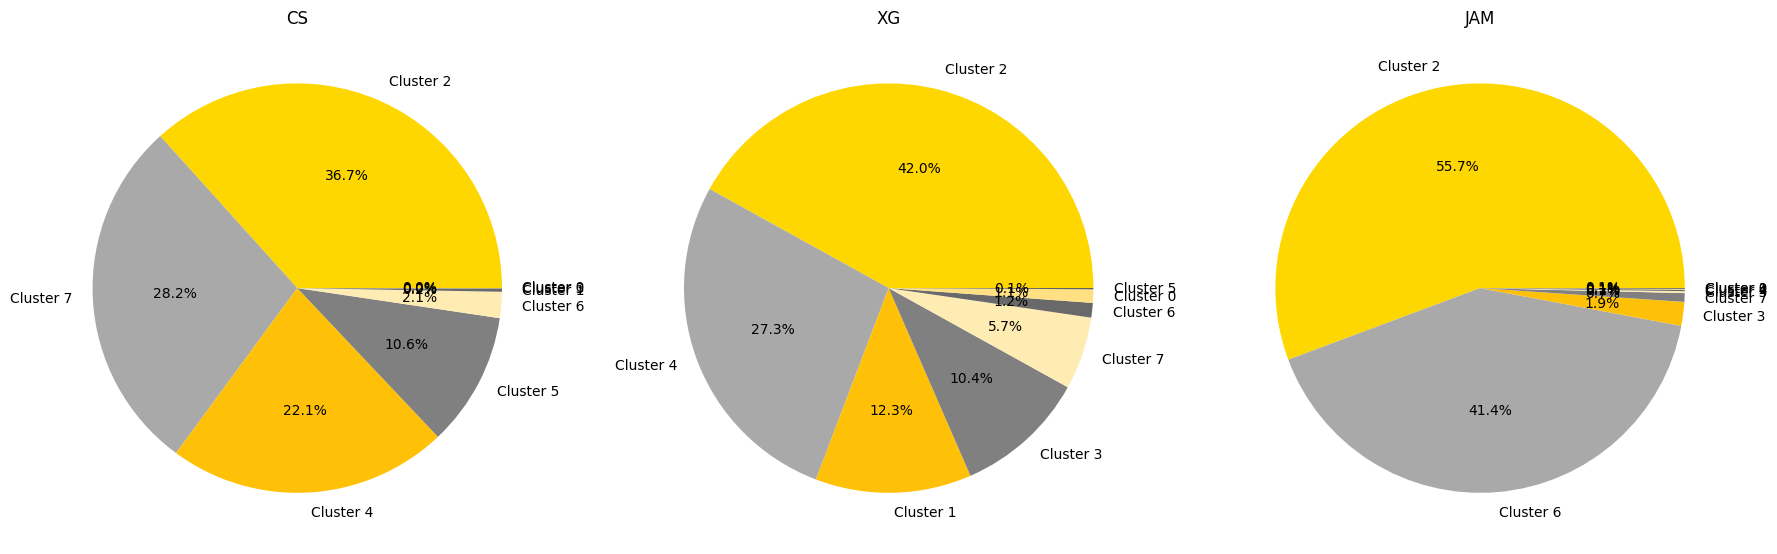

In [ ]:
#Plot the different clusters for each data set
# Calculate percentage of cases in each cluster
def get_cluster_percentages(df):
    return df['Cluster_Labels'].value_counts(normalize=True) * 100

cs_percentages = get_cluster_percentages(df_cs)
xg_percentages = get_cluster_percentages(df_xg)
jam_percentages = get_cluster_percentages(df_jam)

# Define a set of colors in gray and yellow shades
colors = ['#FFD700', '#A9A9A9', '#FFC107', '#808080', '#FFECB3', '#696969', '#FFE082', '#505050']

# Create subplots for pie charts
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Function to generate cluster labels
def get_cluster_labels(percentage_series):
    return [f'Cluster {i}' for i in percentage_series.index]

# Plot df_cs pie chart
axs[0].pie(cs_percentages, labels=get_cluster_labels(cs_percentages), colors=colors[:len(cs_percentages)], autopct='%1.1f%%')
axs[0].set_title('CS')

# Plot df_xg pie chart
axs[1].pie(xg_percentages, labels=get_cluster_labels(xg_percentages), colors=colors[:len(xg_percentages)], autopct='%1.1f%%')
axs[1].set_title('XG')

# Plot df_jam pie chart
axs[2].pie(jam_percentages, labels=get_cluster_labels(jam_percentages), colors=colors[:len(jam_percentages)], autopct='%1.1f%%')
axs[2].set_title('JAM')

# Display the pie charts
plt.tight_layout()

save_path = os.path.join(save_dir, 'Clusters_pie.jpg')
plt.savefig(save_path, format='jpg')

plt.show()

In [ ]:
terms_df = pd.DataFrame(top_terms_per_dataset)

In [ ]:
terms_df['CS']

0    [padre, gente, ganaste, ganara, ganar, gana, g...
1    [futura, arriba, presidenta, claudia, morena, ...
2    [es, narcocandidataclaudia, si, mas, claudia, ...
3    [federales, diputados, junto, plan, fue, fuero...
4    [gracias, solo, corrupta, eres, pinche, voto, ...
5    [jajaja, debate, verdad, pobre, candidata, aca...
6    [es, asi, narcocandidataclaudia, claudia, corr...
7    [tan, jajajaja, gobierno, haciendo, madre, dra...
Name: CS, dtype: object

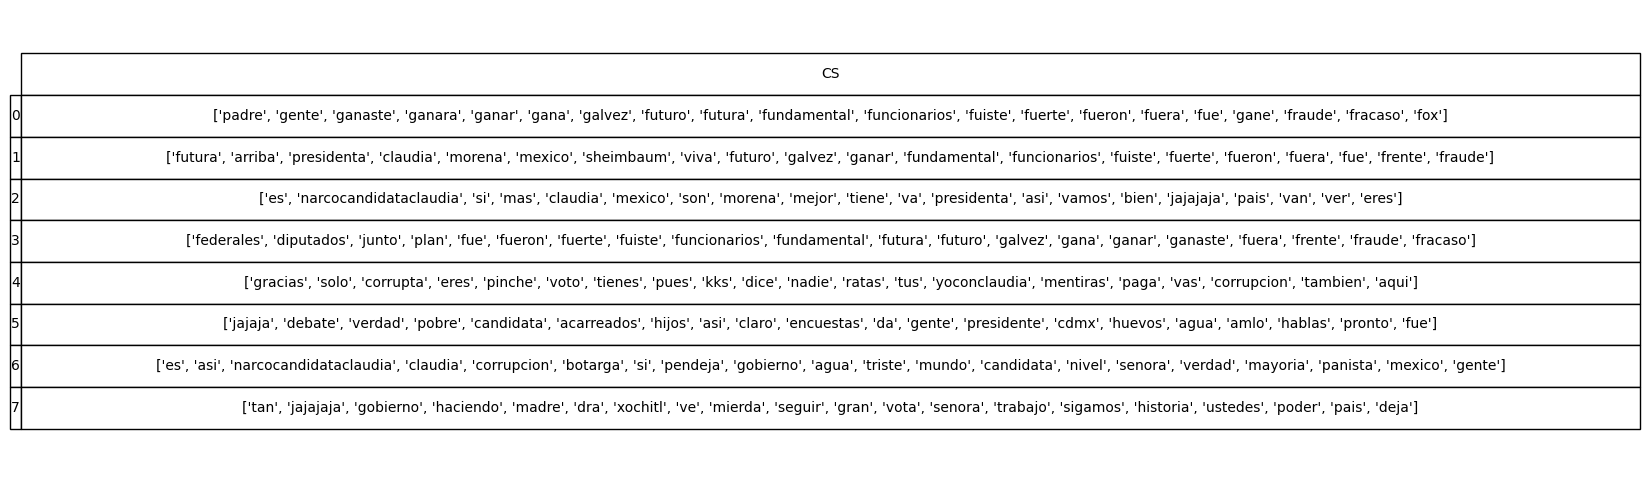

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import table

# Create a figure and an axis with a larger size
fig, ax = plt.subplots(figsize=(20, 6))  # Adjust the size as needed
ax.axis('tight')
ax.axis('off')

# Create the table and add it to the axis with larger font size
tbl = table(ax, terms_df[['CS']], loc='center', cellLoc='center', fontsize=14)  # Increase font size
tbl.scale(1.5, 2.5)

# Adjust the column width if necessary
tbl.auto_set_column_width(col=list(range(len(terms_df.columns))))  # Auto-adjust column widths

save_dir = '/content/plots'
os.makedirs(save_dir, exist_ok=True)  # Ensure the directory exists
save_path = os.path.join(save_dir, 'terms_cs.jpg')

# Save the table as a .jpg file with higher dpi
plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1, dpi=300)  # Use save_path here

plt.show()

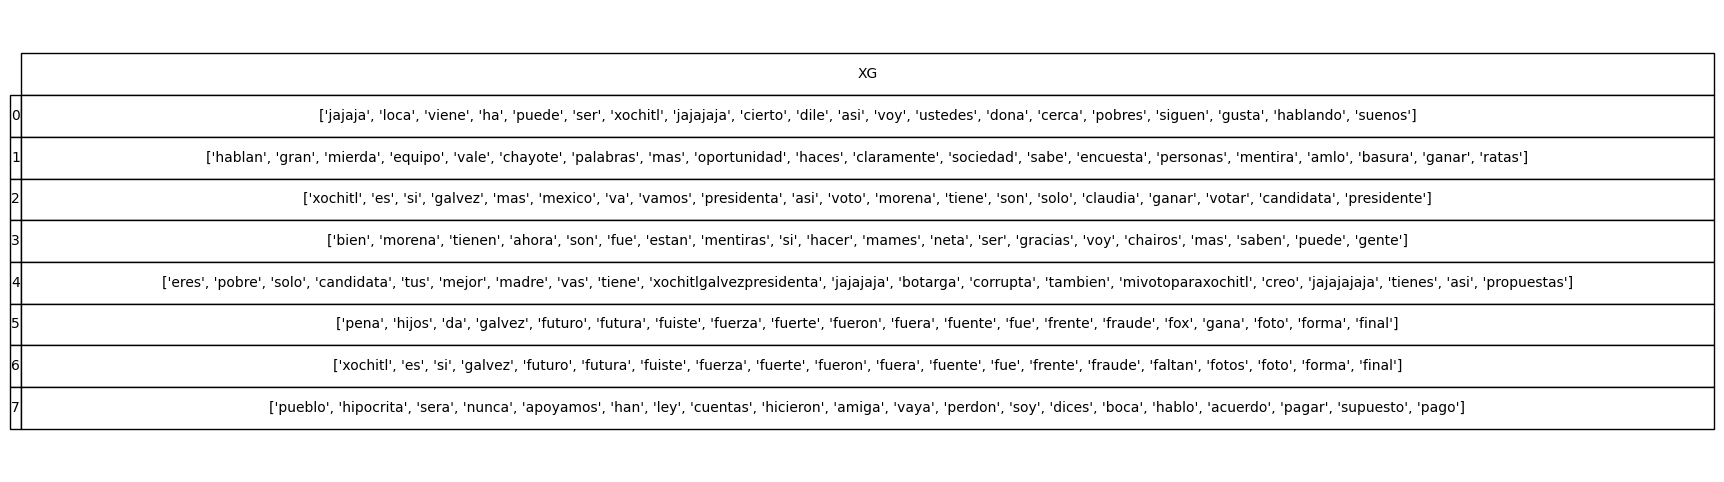

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import table

# Create a figure and an axis with a larger size
fig, ax = plt.subplots(figsize=(20, 6))  # Adjust the size as needed
ax.axis('tight')
ax.axis('off')

# Create the table and add it to the axis with larger font size
tbl = table(ax, terms_df[['XG']], loc='center', cellLoc='center', fontsize=14)  # Increase font size
tbl.scale(1.5, 2.5)

# Adjust the column width if necessary
tbl.auto_set_column_width(col=list(range(len(terms_df.columns))))  # Auto-adjust column widths

save_dir = '/content/plots'
os.makedirs(save_dir, exist_ok=True)  # Ensure the directory exists
save_path = os.path.join(save_dir, 'terms_xg.jpg')

# Save the table as a .jpg file with higher dpi
plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1, dpi=300)  # Use save_path here

plt.show()

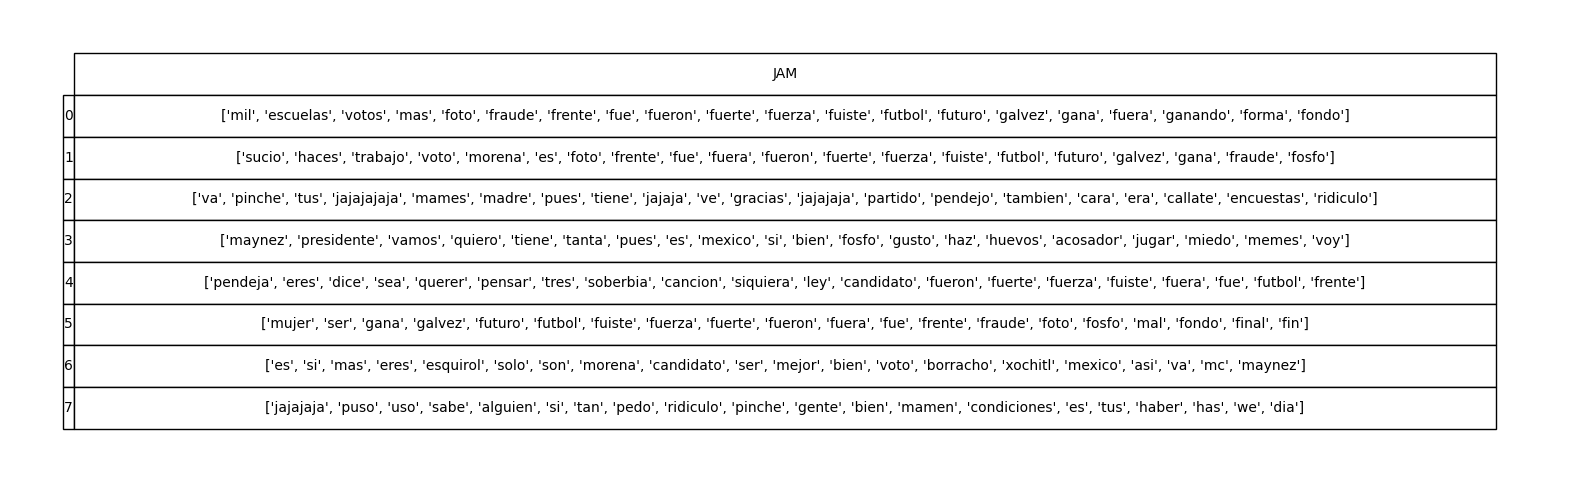

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import table

# Create a figure and an axis with a larger size
fig, ax = plt.subplots(figsize=(20, 6))  # Adjust the size as needed
ax.axis('tight')
ax.axis('off')

# Create the table and add it to the axis with larger font size
tbl = table(ax, terms_df[['JAM']], loc='center', cellLoc='center', fontsize=14)  # Increase font size
tbl.scale(1.5, 2.5)

# Adjust the column width if necessary
tbl.auto_set_column_width(col=list(range(len(terms_df.columns))))  # Auto-adjust column widths

save_dir = '/content/plots'
os.makedirs(save_dir, exist_ok=True)  # Ensure the directory exists
save_path = os.path.join(save_dir, 'terms_jam.jpg')

# Save the table as a .jpg file with higher dpi
plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1, dpi=300)  # Use save_path here

plt.show()

<ipython-input-59-50c4bb16e4cf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cs['Sentiment_Label'] = df_cs['Sentiment'].map(sentiment_map)


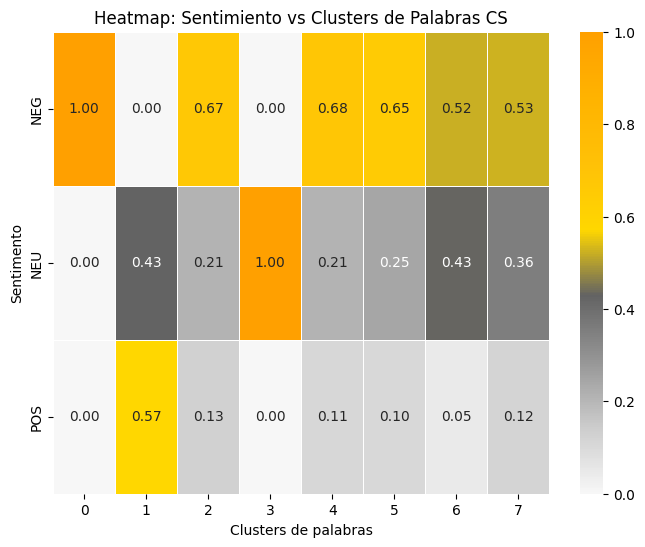

In [ ]:
# Map sentiment values to their respective labels CS
sentiment_map = {0: 'NEG', 1: 'NEU', 2: 'POS'}
df_cs['Sentiment_Label'] = df_cs['Sentiment'].map(sentiment_map)

# Create the crosstab
crosstab = pd.crosstab(df_cs['Sentiment_Label'], df_cs['Cluster_Labels'], normalize='columns')

# Define a custom colormap with yellows and grays
colors = ["#f7f7f7", "#cccccc", "#969696", "#636363", "#ffd700", "#ffc107", "#ffb300", "#ffa000"]
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# Plot the heatmap with the custom colormap
plt.figure(figsize=(8, 6))
sns.heatmap(crosstab, annot=True, fmt=".2f", cmap=cmap, cbar=True, linewidths=.5)

# Customize plot labels and title
plt.title('Heatmap: Sentimiento vs Clusters de Palabras CS')
plt.xlabel('Clusters de palabras')
plt.ylabel('Sentimento')

save_dir = '/content/plots'
os.makedirs(save_dir, exist_ok=True)  # Ensure the directory exists
save_path = os.path.join(save_dir, 'heatmap_CS.jpg')

# Save the heatmap as a .jpg file
plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1, dpi=300)

# Show the plot
plt.show()

<ipython-input-60-c79ff6a488c3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xg['Sentiment_Label'] = df_xg['Sentiment'].map(sentiment_map)


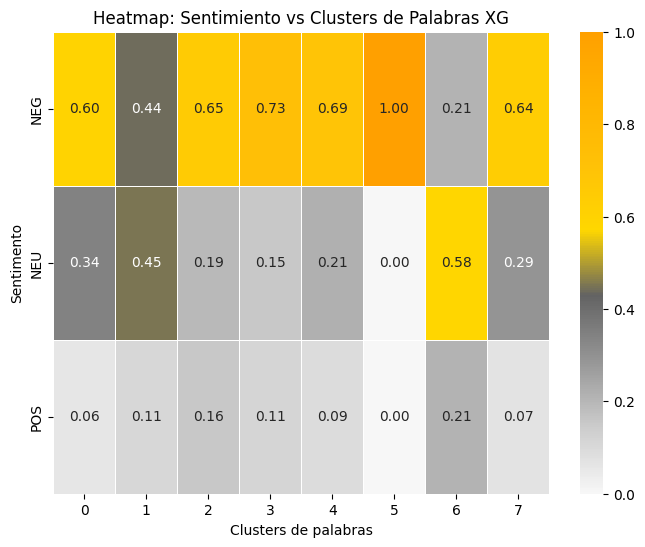

In [ ]:
# Map sentiment values to their respective labels XG
sentiment_map = {0: 'NEG', 1: 'NEU', 2: 'POS'}
df_xg['Sentiment_Label'] = df_xg['Sentiment'].map(sentiment_map)

# Create the crosstab
crosstab = pd.crosstab(df_xg['Sentiment_Label'], df_xg['Cluster_Labels'], normalize='columns')

# Define a custom colormap with yellows and grays
colors = ["#f7f7f7", "#cccccc", "#969696", "#636363", "#ffd700", "#ffc107", "#ffb300", "#ffa000"]
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# Plot the heatmap with the custom colormap
plt.figure(figsize=(8, 6))
sns.heatmap(crosstab, annot=True, fmt=".2f", cmap=cmap, cbar=True, linewidths=.5)

# Customize plot labels and title
plt.title('Heatmap: Sentimiento vs Clusters de Palabras XG')
plt.xlabel('Clusters de palabras')
plt.ylabel('Sentimento')

save_dir = '/content/plots'
os.makedirs(save_dir, exist_ok=True)  # Ensure the directory exists
save_path = os.path.join(save_dir, 'heatmap_XG.jpg')

# Save the heatmap as a .jpg file
plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1, dpi=300)

# Show the plot
plt.show()

<ipython-input-61-ce2ee39ba5ba>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_jam['Sentiment_Label'] = df_jam['Sentiment'].map(sentiment_map)


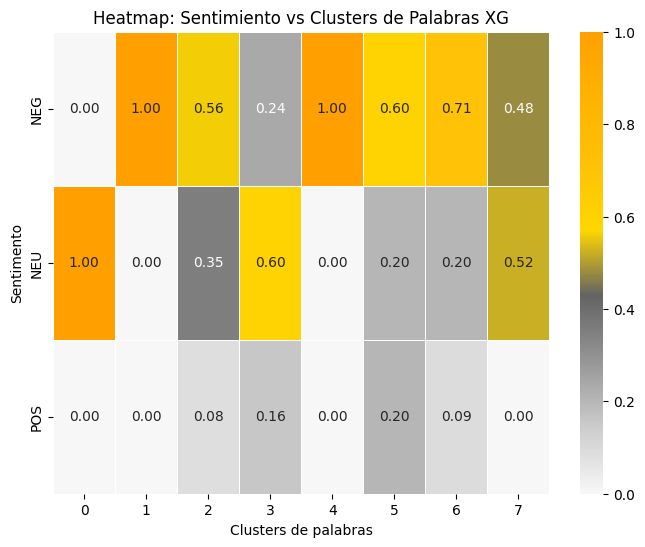

In [ ]:
# Map sentiment values to their respective labels JAM
sentiment_map = {0: 'NEG', 1: 'NEU', 2: 'POS'}
df_jam['Sentiment_Label'] = df_jam['Sentiment'].map(sentiment_map)

# Create the crosstab
crosstab = pd.crosstab(df_jam['Sentiment_Label'], df_jam['Cluster_Labels'], normalize='columns')

# Define a custom colormap with yellows and grays
colors = ["#f7f7f7", "#cccccc", "#969696", "#636363", "#ffd700", "#ffc107", "#ffb300", "#ffa000"]
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# Plot the heatmap with the custom colormap
plt.figure(figsize=(8, 6))
sns.heatmap(crosstab, annot=True, fmt=".2f", cmap=cmap, cbar=True, linewidths=.5)

# Customize plot labels and title
plt.title('Heatmap: Sentimiento vs Clusters de Palabras XG')
plt.xlabel('Clusters de palabras')
plt.ylabel('Sentimento')

save_dir = '/content/plots'
os.makedirs(save_dir, exist_ok=True)  # Ensure the directory exists
save_path = os.path.join(save_dir, 'heatmap_JAM.jpg')

# Save the heatmap as a .jpg file
plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1, dpi=300)

# Show the plot
plt.show()


## **Idelogical Distance**

- In this section we create a metric to measure the distance between the political candiadate speech and what is said in tweeter.

- The measure we use to calculate this distance is Cosine-Similarity, that goes from 0 to 1. The colser the distance between the political specch and what is said in tweeter; the index, will be closer to one.

In [ ]:
#  Function to process the political speeches

def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(f'[{re.escape(string.punctuation)}0-9]', '', text)
    # Remove extra whitespace
    text = re.sub('\s+', ' ', text).strip()
    # Tokenize and remove stopwords
    stop_words = set(stopwords.words('spanish'))
    stemmer = SnowballStemmer('spanish')
    tokens = [stemmer.stem(word) for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

In [ ]:
# Load BERT model and tokenizer
model_name = 'dccuchile/bert-base-spanish-wwm-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/310 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/486k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def get_embeddings(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.detach().numpy()

In [81]:
# Specify the path to your text files
speech_xg_path = '/content/drive/My Drive/XG.txt'
speech_cs_path = '/content/drive/My Drive/CS.txt'
speech_jam_path = '/content/drive/My Drive/JAM.txt'

# Load political speeches
with open(speech_xg_path, 'r', encoding='utf-8') as file:
    speech_xg = file.read()
with open(speech_cs_path, 'r', encoding='utf-8') as file:
    speech_cs = file.read()
with open(speech_jam_path, 'r', encoding='utf-8') as file:
    speech_jam = file.read()

# Preprocess the speeches
speech_xg = preprocess_text(speech_xg)
speech_cs = preprocess_text(speech_cs)
speech_jam = preprocess_text(speech_jam)

In [ ]:
# Preprocess the 'Text' column in each dataframe
df_xg['Text'] = df_xg['Text'].apply(preprocess_text)
df_cs['Text'] = df_cs['Text'].apply(preprocess_text)
df_jam['Text'] = df_jam['Text'].apply(preprocess_text)

<ipython-input-66-49d11264635d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xg['Text'] = df_xg['Text'].apply(preprocess_text)
<ipython-input-66-49d11264635d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cs['Text'] = df_cs['Text'].apply(preprocess_text)
<ipython-input-66-49d11264635d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [ ]:
def calculate_cosine_similarity_with_bert(df, speech):
    # Get embeddings for the speech
    speech_embedding = get_embeddings(speech, tokenizer, model)
    # Get embeddings for all tweets
    tweet_embeddings = df['Text'].apply(lambda x: get_embeddings(x, tokenizer, model)).tolist()
    tweet_embeddings = np.vstack(tweet_embeddings)
    # Calculate cosine similarity between the speech and all tweets
    cosine_similarities = cosine_similarity(speech_embedding, tweet_embeddings).flatten()
    return cosine_similarities


In [ ]:
# Calculate cosine similarity for each dataframe
df_xg['Cosine_Similarity'] = calculate_cosine_similarity_with_bert(df_xg, speech_xg)
df_cs['Cosine_Similarity'] = calculate_cosine_similarity_with_bert(df_cs, speech_cs)
df_jam['Cosine_Similarity'] = calculate_cosine_similarity_with_bert(df_jam, speech_jam)


<ipython-input-68-33449d5bbdc4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xg['Cosine_Similarity'] = calculate_cosine_similarity_with_bert(df_xg, speech_xg)
<ipython-input-68-33449d5bbdc4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cs['Cosine_Similarity'] = calculate_cosine_similarity_with_bert(df_cs, speech_cs)
<ipython-input-68-33449d5bbdc4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [ ]:
print(df_xg['Cosine_Similarity'].describe())
print(df_cs['Cosine_Similarity'].describe())
print(df_jam['Cosine_Similarity'].describe())

count    3294.000000
mean        0.507797
std         0.103059
min         0.096879
25%         0.450779
50%         0.531003
75%         0.584767
max         0.702620
Name: Cosine_Similarity, dtype: float64
count    3152.000000
mean        0.502516
std         0.112346
min         0.116945
25%         0.432513
50%         0.523684
75%         0.591054
max         0.720535
Name: Cosine_Similarity, dtype: float64
count    3351.000000
mean        0.513984
std         0.115807
min         0.056363
25%         0.450674
50%         0.539490
75%         0.601662
max         0.714626
Name: Cosine_Similarity, dtype: float64


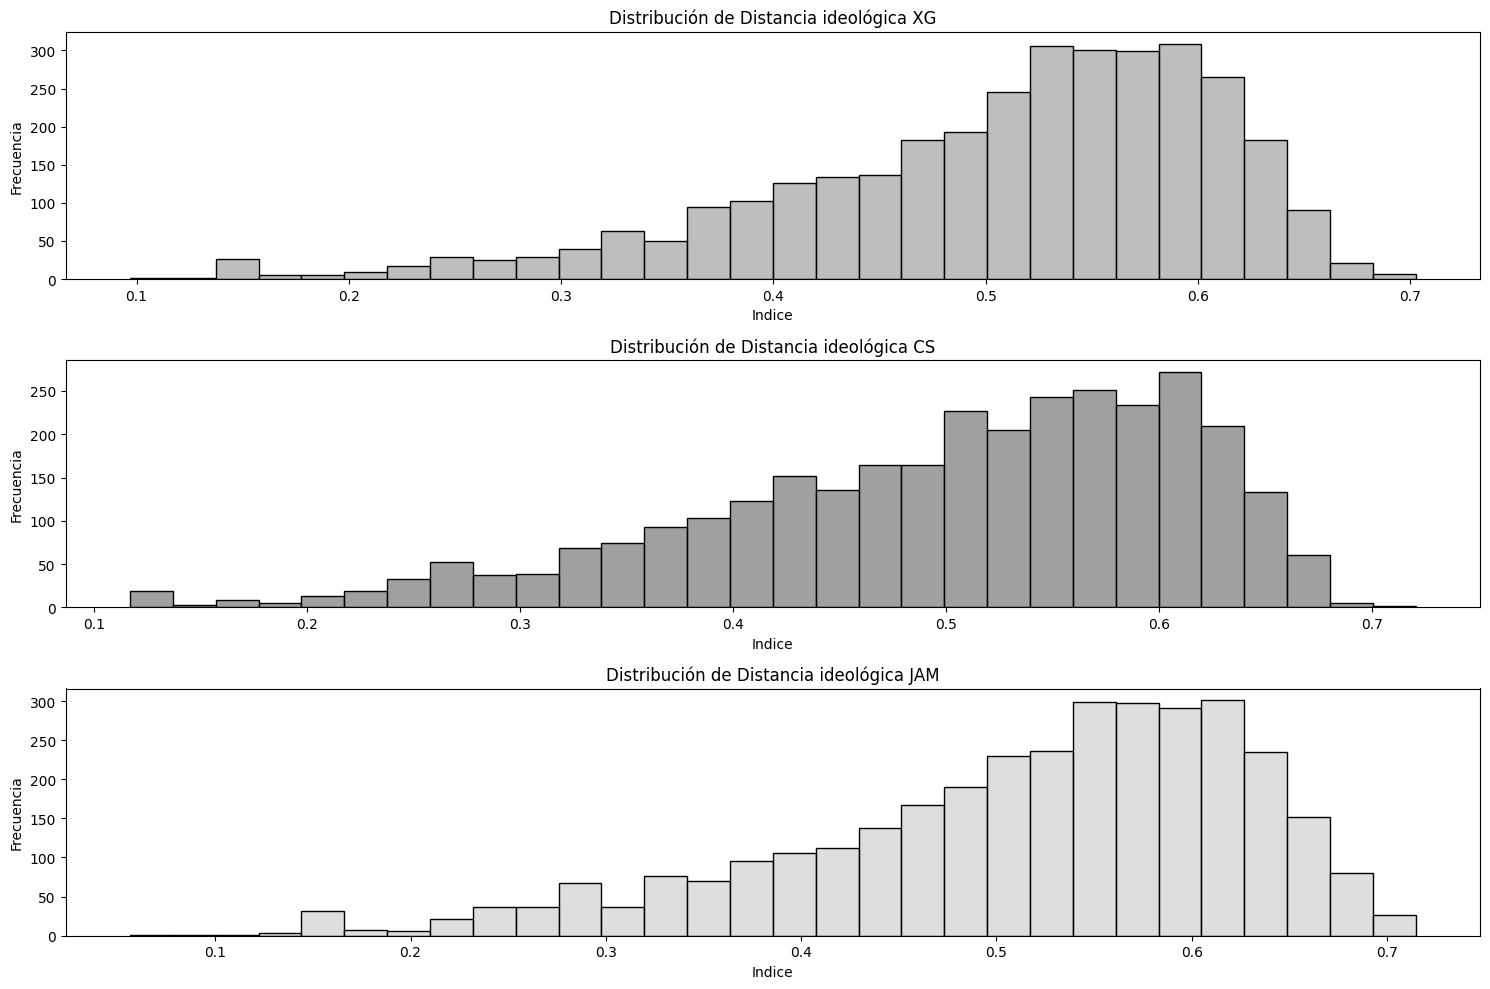

In [ ]:
def plot_cosine_similarity_distributions(df_xg, df_cs, df_jam):
    plt.figure(figsize=(15, 10))

    # Plot for df_xg
    plt.subplot(3, 1, 1)
    sns.histplot(df_xg['Cosine_Similarity'], bins=30, kde=False, color='darkgray')
    plt.title('Distribución de Distancia ideológica XG')
    plt.xlabel('Indice')
    plt.ylabel('Frecuencia')

    # Plot for df_cs
    plt.subplot(3, 1, 2)
    sns.histplot(df_cs['Cosine_Similarity'], bins=30, kde=False, color='gray')
    plt.title('Distribución de Distancia ideológica CS')
    plt.xlabel('Indice')
    plt.ylabel('Frecuencia')

    # Plot for df_jam
    plt.subplot(3, 1, 3)
    sns.histplot(df_jam['Cosine_Similarity'], bins=30, kde=False, color='lightgray')
    plt.title('Distribución de Distancia ideológica JAM')
    plt.xlabel('Indice')
    plt.ylabel('Frecuencia')

    plt.tight_layout()

    # Save the plot
    save_dir = '/content/plots'
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, 'distancias.jpg')
    plt.savefig(save_path)
    plt.show()


 # Call the function to plot the distributions
plot_cosine_similarity_distributions(df_xg, df_cs, df_jam)

## **Preference**

- In this section we propose a composite metric that can be a proxy of psicological adherence, afection, relationship and aquiesence for a politica candidate.


In [ ]:
#Calculate the function to have all three metrics in a separate data frame

def calculate_participation_sentiment_and_similarity(df, start_date):
    # Filter the dataframe to include only rows from the specified start date
    df = df[df['Date'] >= start_date]

    # Prepare the data: count the occurrences of participation = 1 ('Sí') on each date
    participation_counts = df[df['Particip'] == 1].groupby('Date').size()

    # Calculate the total counts of tweets for each day
    total_counts = df.groupby('Date').size()

    # Calculate the percentage of 'Sí' participation for each day
    participation_percentages = (participation_counts / total_counts) * 100

    # Calculate the average of the 'Cosine_Similarity' for each day and convert to percentage
    average_cosine_similarity = df.groupby('Date')['Cosine_Similarity'].mean() * 100

    # Prepare the data: count the occurrences of sentiment = 2 on each date
    sentiment_2_counts = df[df['Sentiment'] == 2].groupby('Date').size()

    # Calculate the percentage of sentiment = 2 for each day
    sentiment_2_percentages = (sentiment_2_counts / total_counts) * 100

    # Combine the results into a new dataframe
    result_df = pd.DataFrame({
        'Participation_Percentage': participation_percentages,
        'Average_Cosine_Similarity_Percentage': average_cosine_similarity,
        'Sentiment_2_Percentage': sentiment_2_percentages
    }).fillna(0)

    return result_df

# Specify the start date
start_date = pd.Timestamp('2024-03-20')

In [ ]:
# Calculate the participation percentages and average cosine similarity for each dataframe
pref_df_cs = calculate_participation_sentiment_and_similarity(df_cs, start_date)
pref_df_xg = calculate_participation_sentiment_and_similarity(df_xg, start_date)
pref_df_jam = calculate_participation_sentiment_and_similarity(df_jam, start_date)


In [ ]:
#Calculate the average for the three columns
pref_df_cs['Avg'] = pref_df_cs[['Participation_Percentage', 'Average_Cosine_Similarity_Percentage', 'Sentiment_2_Percentage']].mean(axis=1)
pref_df_xg['Avg'] = pref_df_xg[['Participation_Percentage', 'Average_Cosine_Similarity_Percentage', 'Sentiment_2_Percentage']].mean(axis=1)
pref_df_jam['Avg'] = pref_df_jam[['Participation_Percentage', 'Average_Cosine_Similarity_Percentage', 'Sentiment_2_Percentage']].mean(axis=1)

In [ ]:
pref_df_cs.head()

,Participation_Percentage,Average_Cosine_Similarity_Percentage,Sentiment_2_Percentage,Avg
Date,,,,
2024-03-20,2.631579,51.042252,10.526316,21.400049
2024-03-22,7.692308,49.890385,7.692308,21.758333
2024-03-23,3.636364,49.464100,14.545455,22.548639
2024-03-25,4.545455,50.583004,16.666667,23.931708
2024-03-26,4.878049,51.714455,14.634146,23.742217


In [ ]:
# Reset the index to make 'Date' a column
pref_df_cs = pref_df_cs.reset_index()
pref_df_xg = pref_df_xg.reset_index()
pref_df_jam = pref_df_jam.reset_index()

# Rename the 'Avg' column in each dataframe to reflect the dataset
pref_df_cs = pref_df_cs.rename(columns={'Avg': 'Avg_CS'})
pref_df_xg = pref_df_xg.rename(columns={'Avg': 'Avg_XG'})
pref_df_jam = pref_df_jam.rename(columns={'Avg': 'Avg_JAM'})

# Merge the dataframes on 'Date'
all_pref = pd.merge(pref_df_cs[['Date', 'Avg_CS']], pref_df_xg[['Date', 'Avg_XG']], on='Date', how='outer')
all_pref = pd.merge(all_pref, pref_df_jam[['Date', 'Avg_JAM']], on='Date', how='outer')

# Set 'Date' as the index
all_pref = all_pref.set_index('Date')



In [ ]:
# Calculate the row sum
all_pref['Total'] = all_pref['Avg_CS'] + all_pref['Avg_XG'] + all_pref['Avg_JAM']

# Calculate the proportions
all_pref['Per_CS'] = all_pref['Avg_CS'] / all_pref['Total']
all_pref['Per_XG'] = all_pref['Avg_XG'] / all_pref['Total']
all_pref['Per_JAM'] = all_pref['Avg_JAM'] / all_pref['Total']

# Drop the 'Total' column as it's no longer needed
all_pref = all_pref.drop(columns=['Total'])

# Verify that the sum of the new columns is 1 for each row
all_pref['Check_Sum'] = all_pref['Per_CS'] + all_pref['Per_XG'] + all_pref['Per_JAM']



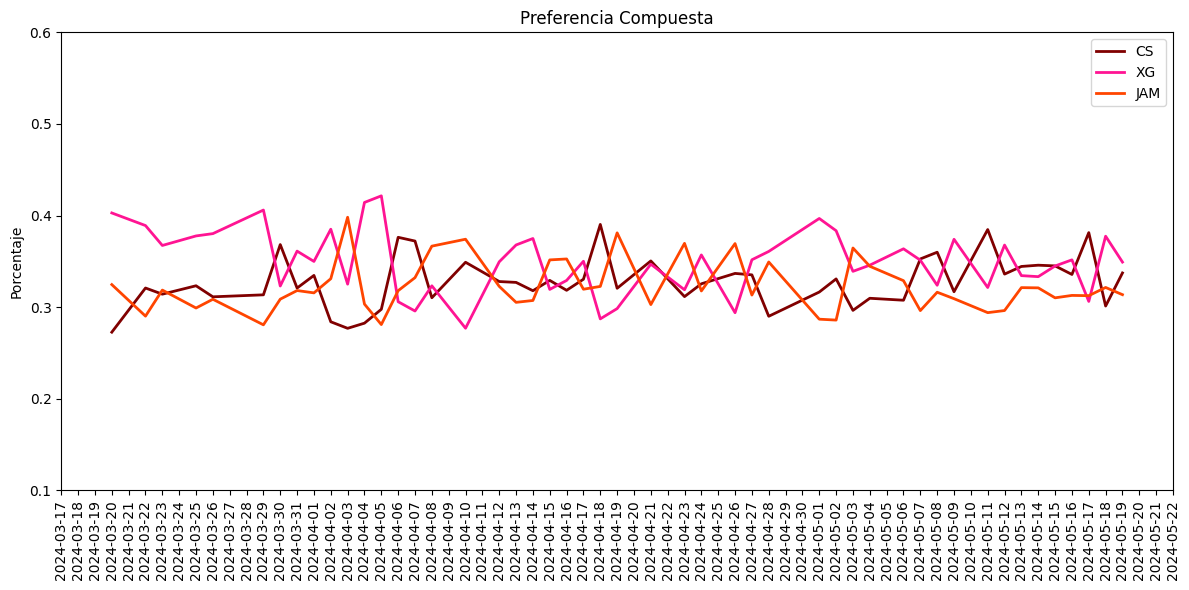

In [ ]:
# Fill NaN values with the mean of the respective columns, then ffill and bfill to ensure continuity
all_pref['Per_CS'] = all_pref['Per_CS'].fillna(all_pref['Per_CS'].mean()).ffill().bfill()
all_pref['Per_XG'] = all_pref['Per_XG'].fillna(all_pref['Per_XG'].mean()).ffill().bfill()
all_pref['Per_JAM'] = all_pref['Per_JAM'].fillna(all_pref['Per_JAM'].mean()).ffill().bfill()

# Plot the time series
plt.figure(figsize=(12, 6))

# Plot each line with the specified colors and increased line width
plt.plot(all_pref.index, all_pref['Per_CS'], label='CS', color='maroon', linewidth=2)  # guinda
plt.plot(all_pref.index, all_pref['Per_XG'], label='XG', color='deeppink', linewidth=2)    # pink
plt.plot(all_pref.index, all_pref['Per_JAM'], label='JAM', color='orangered', linewidth=2) # bright orange

# Set the title and labels
plt.title('Preferencia Compuesta')
plt.ylabel('Porcentaje')

# Set y-axis limits
plt.ylim(0.10, 0.60)

# Rotate the x-axis labels and set all dates as ticks
plt.xticks(ticks=all_pref.index, labels=all_pref.index.strftime('%Y-%m-%d'), rotation=90)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Set major ticks to daily
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=90)  #

# Add a legend
plt.legend()

# Adjust layout to fit all labels
plt.tight_layout()

# Save the plot
save_dir = '/content/plots'
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, 'Preferencia.jpg')
plt.savefig(save_path)


# Display the plot
plt.show()


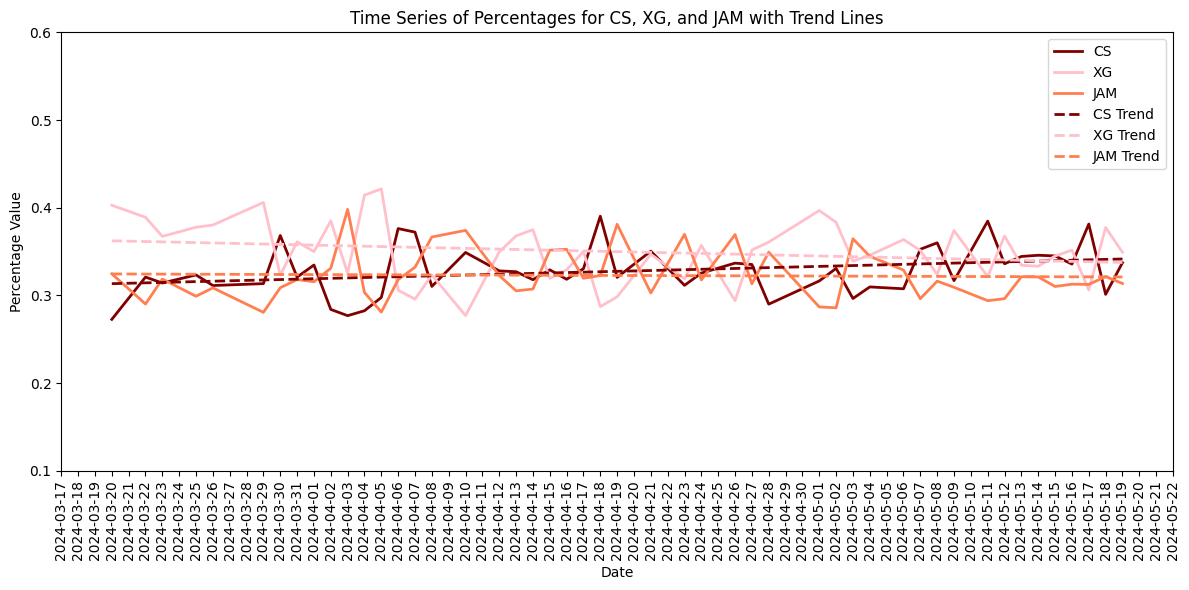

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Fill NaN values with the mean of the respective columns, then ffill and bfill to ensure continuity
all_pref['Per_CS'] = all_pref['Per_CS'].fillna(all_pref['Per_CS'].mean()).ffill().bfill()
all_pref['Per_XG'] = all_pref['Per_XG'].fillna(all_pref['Per_XG'].mean()).ffill().bfill()
all_pref['Per_JAM'] = all_pref['Per_JAM'].fillna(all_pref['Per_JAM'].mean()).ffill().bfill()

# Prepare the date data for regression (convert dates to ordinal for linear regression)
X = all_pref.index.map(pd.Timestamp.toordinal).values.reshape(-1, 1)

# Fit linear regression models for each series
model_cs = LinearRegression().fit(X, all_pref['Per_CS'])
model_xg = LinearRegression().fit(X, all_pref['Per_XG'])
model_jam = LinearRegression().fit(X, all_pref['Per_JAM'])

# Predict the trend lines
trend_cs = model_cs.predict(X)
trend_xg = model_xg.predict(X)
trend_jam = model_jam.predict(X)

# Plot the time series
plt.figure(figsize=(12, 6))

# Plot each line with the specified colors and increased line width
plt.plot(all_pref.index, all_pref['Per_CS'], label='CS', color='maroon', linewidth=2)  # guinda
plt.plot(all_pref.index, all_pref['Per_XG'], label='XG', color='pink', linewidth=2)    # pink
plt.plot(all_pref.index, all_pref['Per_JAM'], label='JAM', color='#FF7F50', linewidth=2) # brighter orange

# Plot the trend lines
plt.plot(all_pref.index, trend_cs, label='CS Trend', color='maroon', linestyle='--', linewidth=2)
plt.plot(all_pref.index, trend_xg, label='XG Trend', color='pink', linestyle='--', linewidth=2)
plt.plot(all_pref.index, trend_jam, label='JAM Trend', color='#FF7F50', linestyle='--', linewidth=2)

# Set the title and labels
plt.title('Time Series of Percentages for CS, XG, and JAM with Trend Lines')
plt.xlabel('Date')
plt.ylabel('Percentage Value')

# Set y-axis limits
plt.ylim(.10, .60)

# Format the date labels on the x-axis
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Set major ticks to daily
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=90)  # Rotate date labels to be vertical

# Add a legend
plt.legend()

# Adjust layout to fit all labels
plt.tight_layout()

# Display the plot
plt.show()


## **Saving all the images**

In [ ]:
#Dowload the plots to desktop
import shutil
from google.colab import files

# Zip the directory
shutil.make_archive('/content/plots', 'zip', '/content/plots')

# # Download the zip file
files.download('/content/plots.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>